In [1]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import PartialDependenceDisplay
import statsmodels.api as sm

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')

# Exploratory Data Analysis (EDA)

In [3]:
# Load the dataset
# CHANGE THE PATH IF USING GOOGLE COLAB
path = 'song_data.csv'
df = pd.read_csv(path)

# Drop unnecessary column
df = df.drop('song_name', axis=1)

# For later data manipulation
df_original = df.copy()

# Extract target variable and features
target = 'song_popularity'
y = df[target]
X = df.drop(target, axis=1)

# Simple summary
print(f"Total samples: {df.shape[0]}")
print(f"Total Features: {df.shape[1]}")
print(f"Missing Values: {df.isnull().sum().sum()}")
print(f"Duplicated Rows: {df.duplicated().sum()}")
print(f"\nTarget: {target}")
print(f"Number of Features: {X.shape[1]}")

Total samples: 18835
Total Features: 14
Missing Values: 0
Duplicated Rows: 3911

Target: song_popularity
Number of Features: 13


- **Dữ liệu khá lớn:** 18,835 mẫu với 13 biến độc lập để dự đoán popularity
- **Không có missing values:** Dữ liệu đã được thu thập đầy đủ, không cần xử lý giá trị thiếu
- **Có duplicated rows (20.8%):** 3,911/18,835 dòng bị trùng lặp - **cần xóa** để tránh overfitting và bias trong mô hình

In [4]:
# Check first 5 rows
display(df.head())

# Check data types and non-null counts
display(df.info())

# Basic statistics
display(df.describe())

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


None

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,18835.000000,1.883500e+04,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000
mean,52.991877,2.182116e+05,0.258539,0.633348,0.644995,0.078008,5.289196,0.179650,-7.447435,0.628139,0.102099,121.073154,3.959119,0.527967
std,21.905654,5.988754e+04,0.288719,0.156723,0.214101,0.221591,3.614595,0.143984,3.827831,0.483314,0.104378,28.714456,0.298533,0.244632
min,0.000000,1.200000e+04,0.000001,0.000000,0.001070,0.000000,0.000000,0.010900,-38.768000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,1.843395e+05,0.024100,0.533000,0.510000,0.000000,2.000000,0.092900,-9.044000,0.000000,0.037800,98.368000,4.000000,0.335000
50%,56.000000,2.113060e+05,0.132000,0.645000,0.674000,0.000011,5.000000,0.122000,-6.555000,1.000000,0.055500,120.013000,4.000000,0.527000
75%,69.000000,2.428440e+05,0.424000,0.748000,0.815000,0.002570,8.000000,0.221000,-4.908000,1.000000,0.119000,139.931000,4.000000,0.725000
max,100.000000,1.799346e+06,0.996000,0.987000,0.999000,0.997000,11.000000,0.986000,1.585000,1.000000,0.941000,242.318000,5.000000,0.984000


**df.head()**
- Dataset: 14 cột (1 target `song_popularity` + 13 features)
- **Kiểu dữ liệu:** 5 biến int64 (`song_popularity`, `song_duration_ms`, `key`, `audio_mode`, `time_signature`) và 9 biến float64 (các audio features)
- **Các biến categorical được mã hóa số:** `key` (0-11: 12 tông nhạc), `audio_mode` (0/1: minor/major), `time_signature` (0-5: nhịp) → **cần dummy encoding** trước khi train
- **Audio features đã normalize:** `acousticness`, `danceability`, `energy`, `liveness`, `loudness`, `speechiness`, `tempo`, `audio_valence` đều trong khoảng [0,1] hoặc đã scale

**df.info()**
- **Không có missing values** (18,835 non-null cho tất cả) → không cần imputation
- Tất cả các cột đều có kiểu dữ liệu phù hợp với nội dung (Int, float).

**df.describe()**

*Biến target:*
- `song_popularity`: mean=53, std=21.9, range [0,100] → phân bố tương đối cân bằng, không quá lệch, phù hợp cho mô hình hồi quy

*Outliers nghiêm trọng:*
- `song_duration_ms`: max=1.8M ms (≈30 phút) trong khi 75% chỉ 242k (4 phút) → có bài hát cực dài bất thường → **cần filter**
- `loudness`: min=-38.8 dB (quá thấp, gần như không nghe được) trong khi 25% là -9.04 → **cần xử lý lower outliers bằng capping**
- `tempo`: min=0 (không hợp lý, không thể không có nhịp) → **cần loại bỏ**

*Skewness nghiêm trọng:*
- `instrumentalness`: 75%=0.0025 nhưng max=0.997 → hầu hết bài không có instrumental, một số ít có rất nhiều → **zero-inflated, cần binary encoding**
- `speechiness`: tương tự instrumentalness, phân bố lệch phải → **cần log1p transform** (vì có giá trị 0)
- `liveness`, `song_duration_ms`: cũng có dấu hiệu lệch → **cần log transform**

*Vấn đề scale:*
- `song_duration_ms` có scale ~200,000 trong khi các audio features [0,1] → **bắt buộc phải scaling** (RobustScaler) trước khi train mô hình regularization (Ridge/Lasso)
- `tempo`: mean=121, scale khác hẳn các biến [0,1] → **cũng cần scaling**

In [5]:
# Check unique values in each column
print("Unique values in each column:")
print(df.nunique())

Unique values in each column:
song_popularity       101
song_duration_ms    11771
acousticness         3209
danceability          849
energy               1132
instrumentalness     3925
key                    12
liveness             1425
loudness             8416
audio_mode              2
speechiness          1224
tempo               12112
time_signature          5
audio_valence        1246
dtype: int64


- **Biến categorical:** `key` (12 giá trị), `audio_mode` (2 giá trị), `time_signature` (5 giá trị) → là categorical, cần dummy encoding
- **Target:** `song_popularity` có 101 giá trị khác nhau [0-100] → biến liên tục, phù hợp cho regression
- **Numerical features:** Có đủ số lượng giá trị unique (từ 849 đến 12,112) → biến liên tục.

In [6]:
# Classify features by type and extract categorical and numerical features
categorical_features = ['key', 'audio_mode', 'time_signature']
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
numerical_features = [col for col in numerical_features if col not in categorical_features]

print('Categorical Features:', len(categorical_features))
print('Numerical Features:', len(numerical_features))

Categorical Features: 3
Numerical Features: 10



Target Variable Distribution:


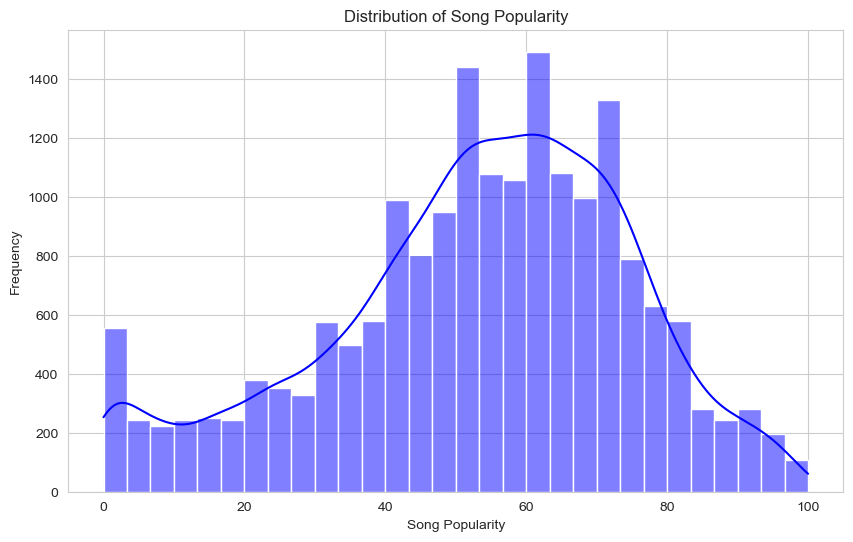

In [7]:
# Analyze target variable distribution
print("\nTarget Variable Distribution:")
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True, color='blue')
plt.title('Distribution of Song Popularity')
plt.xlabel('Song Popularity')
plt.ylabel('Frequency')
plt.show()

- **Phân bố gần chuẩn (normal distribution):** Biểu đồ có hình dạng chuông, tập trung quanh giá trị trung bình ~53, không bị lệch trái hay phải nghiêm trọng
- **Đỉnh tại khoảng 50-60:** Phần lớn bài hát có độ phổ biến trung bình, ít bài có độ phổ biến cực thấp (0-20) hoặc cực cao (80-100)
- **Phân bố tốt cho mô hình hồi quy:** Không có class imbalance, variance đồng đều → thuận lợi cho Linear Regression
- **Có một số multimodal nhẹ:** Có thể thấy vài đỉnh phụ nhỏ → cho thấy có thể có nhiều nhóm bài hát với popularity khác nhau (viral hits vs niche songs)


Categorical Feature Distributions:


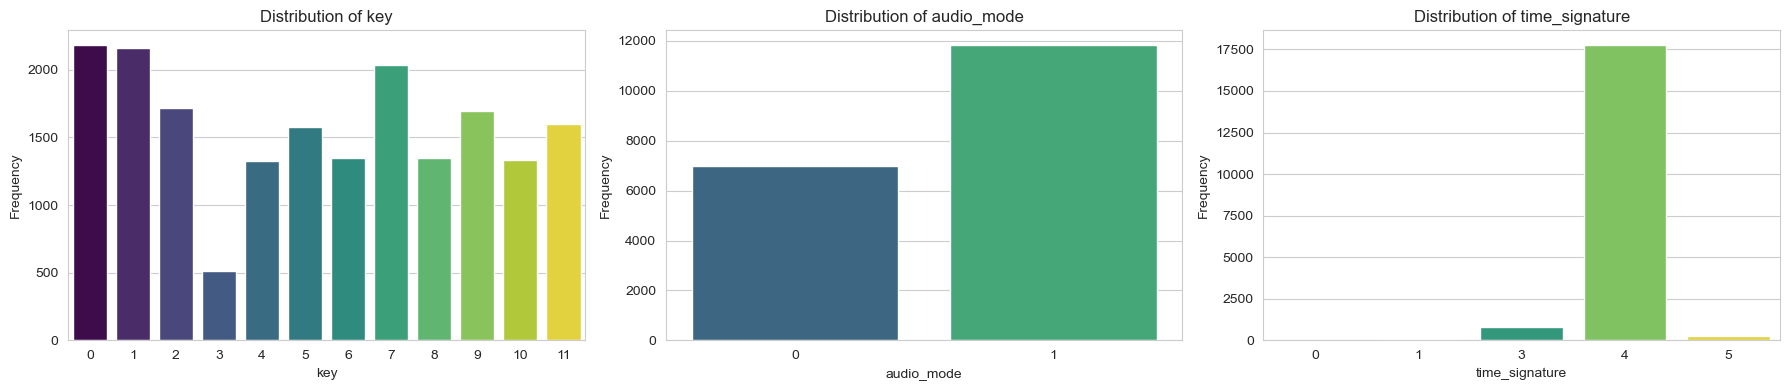

In [8]:
# Visualize categorical features
# Subplots for categorical features
print("\nCategorical Feature Distributions:")
cat_features = len(categorical_features)
fig, axes = plt.subplots(1, cat_features, figsize=(6 * cat_features, 4))

for idx, col in enumerate(categorical_features):
    sns.countplot(data=df, x=col, palette='viridis', hue=col, legend=False, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**key:**
- Phân bố không đồng đều. Class imbalance nhẹ có thể làm mô hình thiên vị về các key phổ biến
-> dùng dummy encoding với `drop_first=True` để tránh multicollinearity trap

**audio_mode:**
- Phân bố cực kỳ không cân bằng, mode 1 chiếm tuyệt đối, mode 0 chỉ một nữa.
- Imbalance nghiêm trọng (tỉ lệ ~7:1) → mô hình có thể học rằng "mode 1 luôn là default" -> giảm khả năng phân biệt
- Giữ nguyên vì đây là đặc tính thực tế của dữ liệu. Binary variable nên không cần encoding thêm

**time_signature:**
- Phân bố cực đoan, giá trị 4 chiếm >90%, các giá trị khác (3, 5) rất hiếm
- Extreme imbalance (~95:5) → feature gần như không có variability, ít giá trị dự đoán
-> dummy encoding


Numerical Feature Distributions:


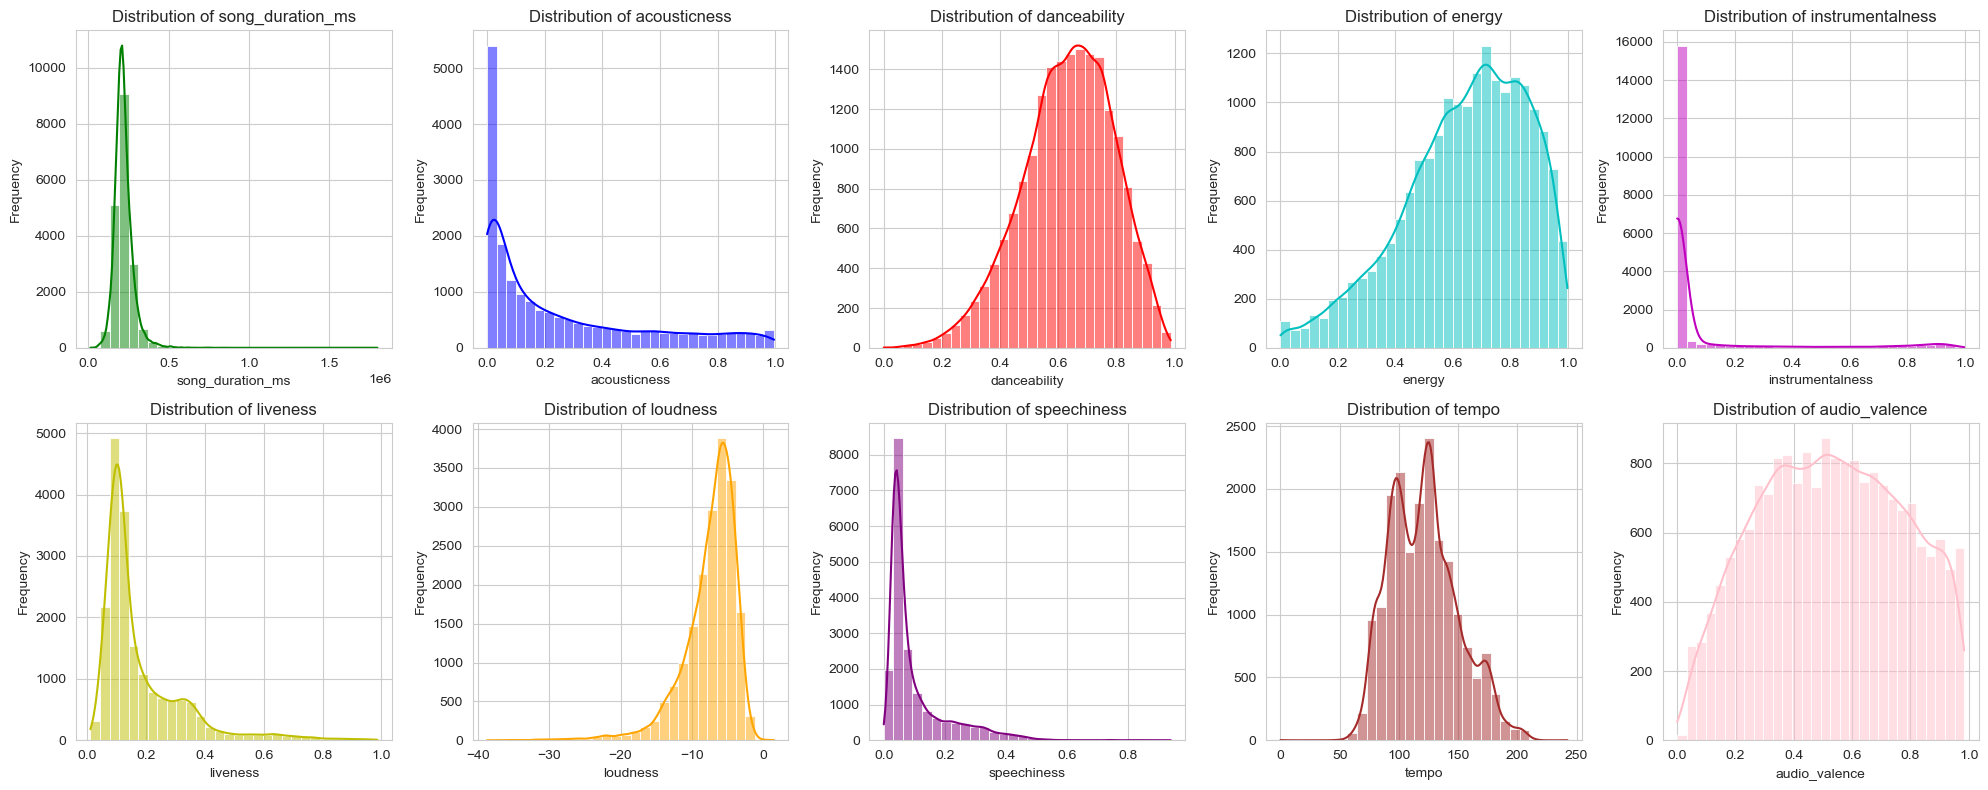


Outlier Visualization for Numerical Features:


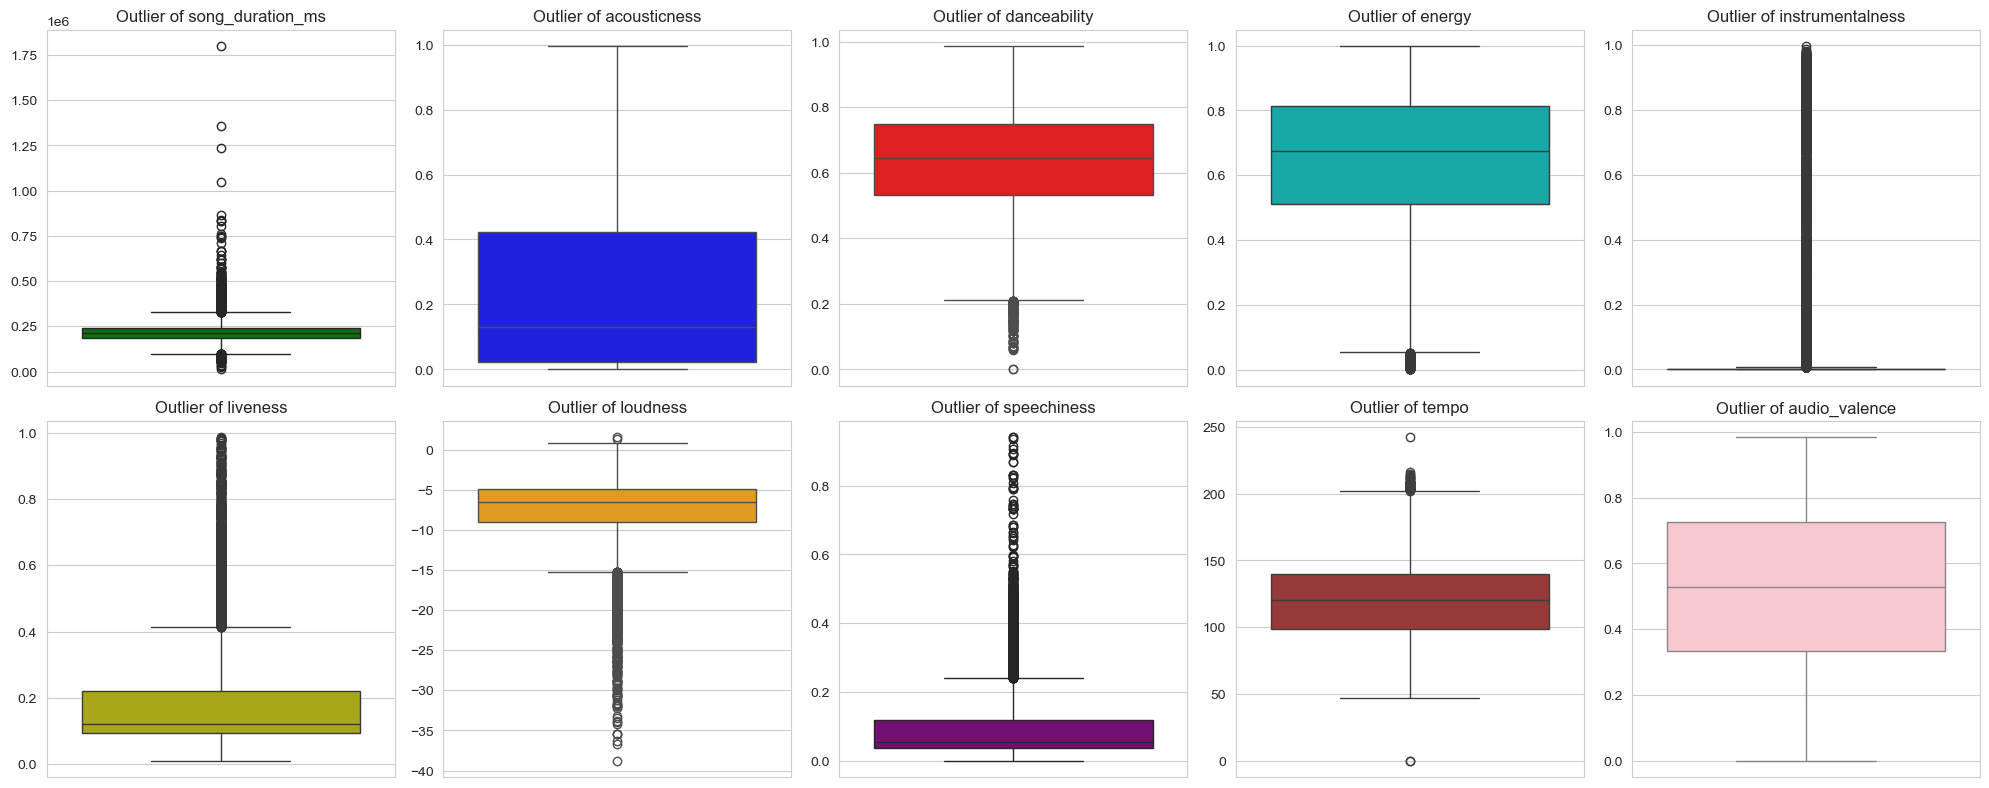

In [9]:
# Visualize numerical features
# Color palette
colors = ['g', 'b', 'r', 'c', 'm', 'y', 'orange', 'purple', 'brown', 'pink']

num_features = len(numerical_features)
n_cols = 5
n_rows = math.ceil(num_features / n_cols)

# Subplot for numerical features
print("\nNumerical Feature Distributions:")
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    sns.histplot(df[col], bins=30, kde=True, color=colors[idx % len(colors)], ax=axes[idx])
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

# Hide any unused subplots
for idx in range(num_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Visualize outliers
print("\nOutlier Visualization for Numerical Features:")
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    sns.boxplot(y=df[col], color=colors[idx % len(colors)], ax=axes[idx])
    axes[idx].set_title(f'Outlier of {col}')
    axes[idx].set_ylabel('')

# Hide any unused subplots
for idx in range(num_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**song_duration_ms:**
- Right-skewed nghiêm trọng, phần lớn bài 2.5-4 phút (~150k-250k ms), có outliers cực lớn (>1M ms, ~30 phút)
- Outliers gây nhiễu, làm hệ số hồi quy không ổn định
-> log transformation để giảm skewness, filter bài quá ngắn (<30s)

**acousticness:**
- Bimodal (hai đỉnh): đỉnh gần 0 (không acoustic) và đỉnh gần 1 (acoustic thuần túy)
- Phân bố không đồng nhất, khó fit bằng linear regression đơn giản
-> polynomial features có thể capture quan hệ phi tuyến

**danceability:**
- Gần chuẩn, tập trung 0.4-0.7, phân bố đồng đều
- Tốt cho regression, không cần xử lý đặc biệt
-> giữ nguyên

**energy:**
- Uniform-like, phân bố đều từ 0-1, tập trung nhẹ ở giá trị cao
- Tốt cho mô hình, không có vấn đề skewness
-> giữ nguyên, nhưng cần kiểm tra multicollinearity với loudness (corr cao)

**instrumentalness:**
- Zero-inflated: >90% giá trị = 0 (có vocals), một số ít rất cao (instrumental thuần)
- Không phù hợp linear regression (phân bố không liên tục)
-> chuyển thành binary `is_instrumental` (>0.5) (theo Spotify)

**liveness:**
- Right-skewed, phần lớn <0.3, một số ít cao (live performance)
- Skewness làm giảm hiệu quả mô hình
-> log transformation

**loudness:**
- Left-skewed, tập trung -5 đến -10 dB, outliers cực thấp (<-30 dB, gần không nghe được)
- Lower outliers gây nhiễu
-> capping ở 1st percentile

**speechiness:**
- Right-skewed + zero-inflated, phần lớn <0.2, có giá trị = 0, một số ít rất cao (spoken word)
- Skewness + zero values
-> log1p transformation để xử lý cả skewness và zero

**tempo:**
- Gần chuẩn, tập trung 100-140 BPM, phân bố đồng đều
- Tốt cho regression, nhưng scale khác biệt (~120) so với các audio features [0,1]
-> cần scaling (RobustScaler)

**audio_valence:**
- Uniform-like, phân bố đều từ 0-1
- Tốt cho mô hình
-> giữ nguyên


Categorical Features vs Target Variable:


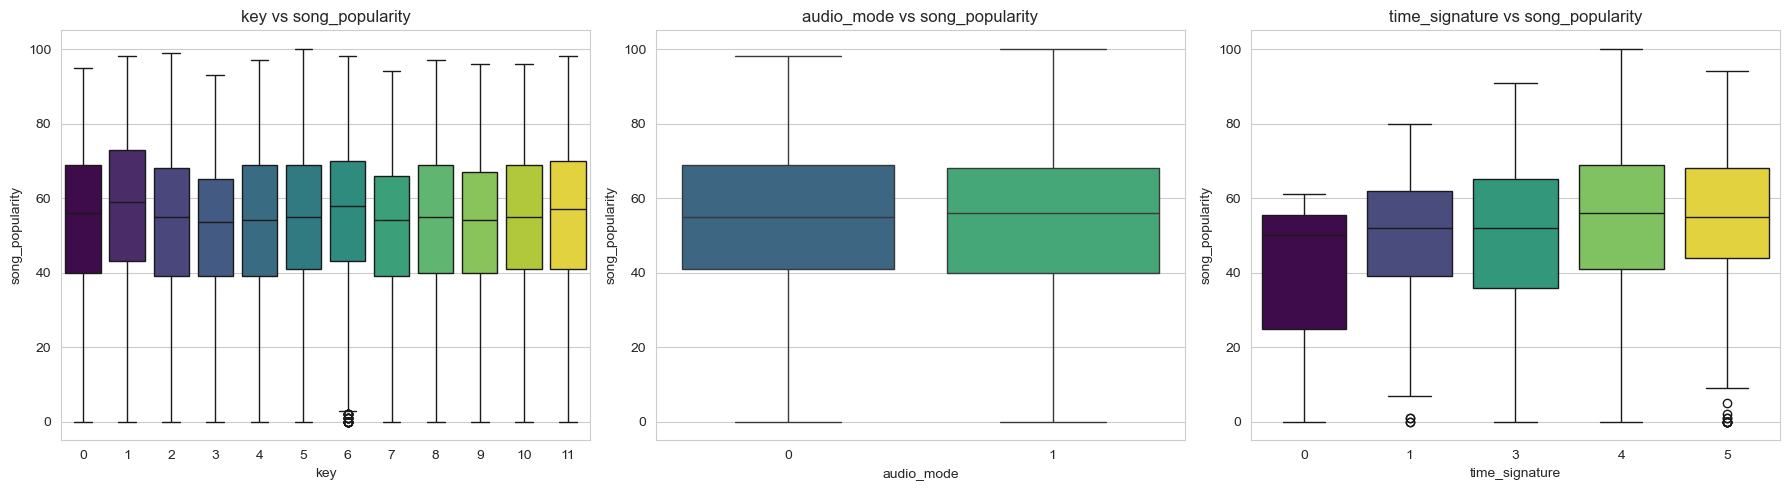

In [10]:
# Categorical vs Target Visualization (boxplot)
print("\nCategorical Features vs Target Variable:")
fig, axes = plt.subplots(1, cat_features, figsize=(6 * cat_features, 5))

for idx, col in enumerate(categorical_features):
    sns.boxplot(data=df, x=col, y=target, palette='viridis', hue=col, legend=False, ax=axes[idx])
    axes[idx].set_title(f'{col} vs {target}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel(target)

plt.tight_layout()
plt.show()

**key:**
- Median popularity khá đồng đều (~55-56) giữa các key, không có key nào nổi bật hơn hẳn
- Phạm vi IQR (hộp) và whisker (râu) tương tự nhau giữa các key → variance của popularity không phụ thuộc nhiều vào key
- Có outliers ở key=6 (popularity gần 0) → một số bài hát ở key này cực kỳ không phổ biến
-> Key có tương quan yếu với popularity

**audio_mode:**
- Mode 1 (major): median ~54, IQR rộng (40-66)
- Mode 0 (minor): median ~56, IQR rộng (42-68)
- Sự khác biệt median nhẹ (~2 điểm), phân bố khá chồng lấp → tương quan yếu với popularity
- Mode 0 có xu hướng popularity cao hơn một chút, nhưng không đáng kể
-> Audio_mode có thể có ảnh hưởng nhỏ.

**time_signature:**
- Time_signature=4: median ~55, IQR (40-68) → phân bố chuẩn, đa số bài hát
- Time_signature=5: nhưng IQR rất rộng. Điều này cho thấy nhóm này có Popularity trung bình cao hơn nhưng biến động lớn.
- Time_signature=3: median ~ 55, IQR rộng. Tương tự nhịp 4, nhưng varaiance Popularity cao hơn.
- Time_signature=0,1: có outliers thấp (popularity ~0-5) → bài hát đặc biệt
- Không có sự khác biệt rõ ràng giữa các nhịp → time_signature có tương quan rất yếu với popularity


Numerical Features vs Target Variable:


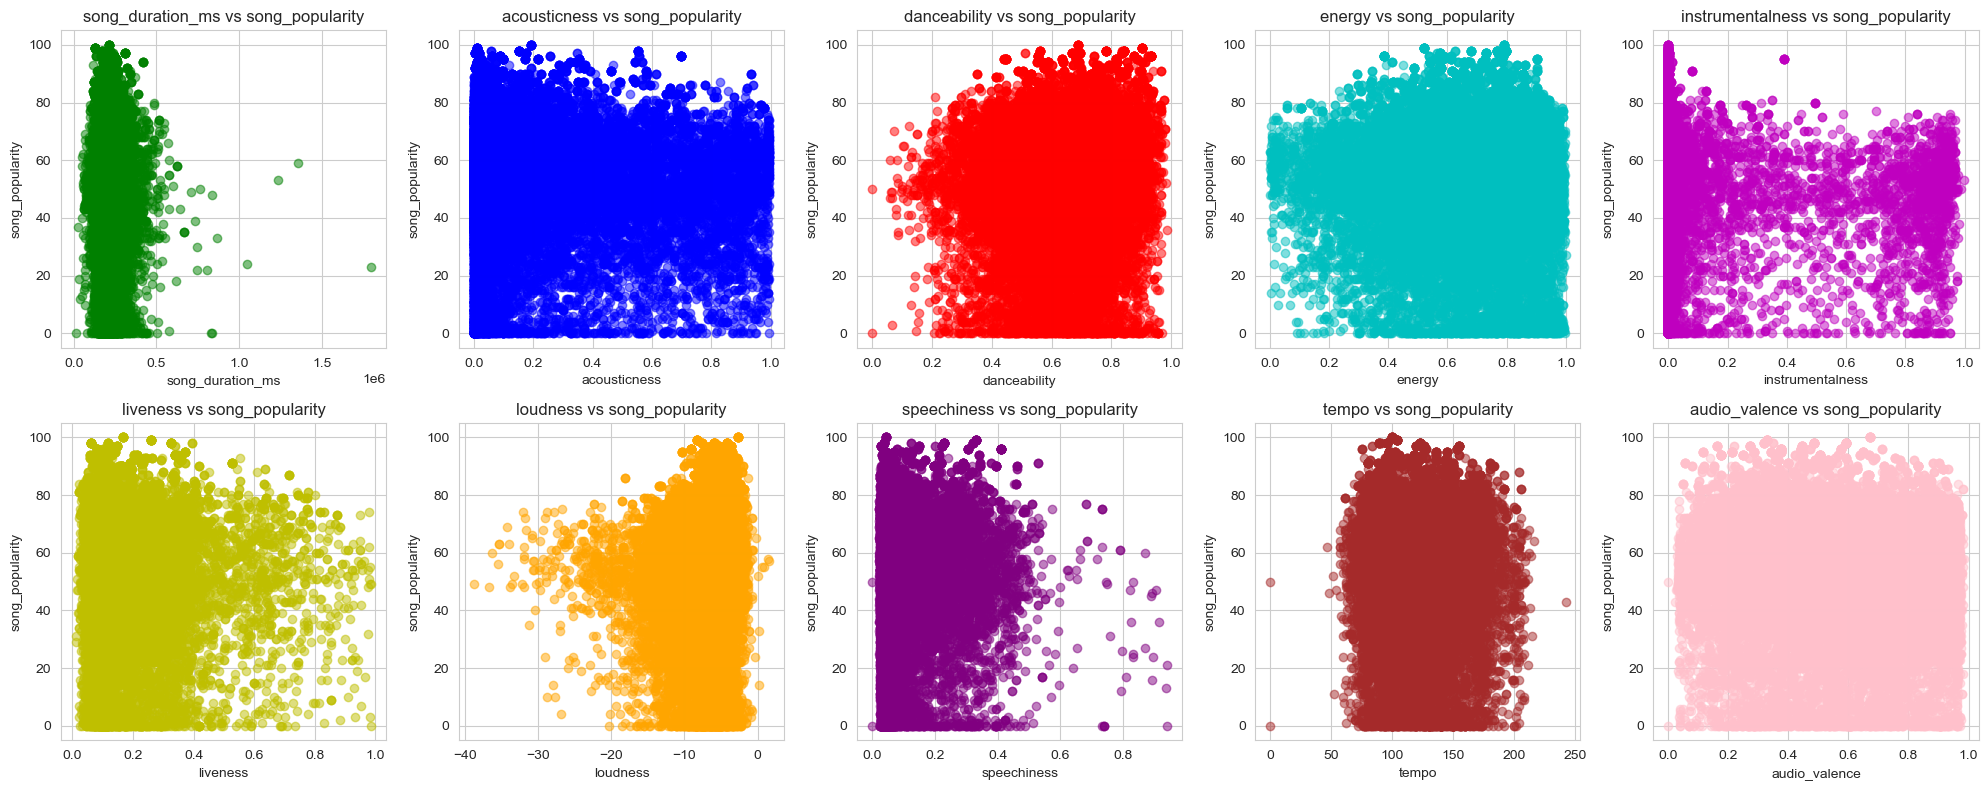

In [11]:
# Numerical Features vs Target Visualization (scatter plots)
print("\nNumerical Features vs Target Variable:")
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for idx, col in enumerate(numerical_features):
    axes[idx].scatter(df[col], df[target], alpha=0.5, color=colors[idx % len(colors)])
    axes[idx].set_title(f'{col} vs {target}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel(target)

# Hide any unused subplots
for idx in range(num_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**song_duration_ms:**
- Phần lớn bài tập trung ở 150k-250k ms, popularity phân bố đều từ 0-100 → không có mối quan hệ tuyến tính rõ ràng
- Bài dài (>1M ms) có popularity thấp → outliers này có thể gây nhiễu
-> Tương quan yếu với popularity, nhưng sau log transformation có thể cải thiện

**acousticness:**
- Scatter plot phân tán đều khắp không gian, không có pattern rõ ràng
- Bimodal (tập trung ở 0 và 1) nhưng mỗi nhóm đều có popularity đa dạng
-> Không có quan hệ tuyến tính mạnh, cần polynomial features để capture non-linear relationship

**danceability:**
- Phân tán đều, tập trung ở 0.4-0.8, popularity phủ đều từ 0-100
- Có xu hướng tăng thuận nhưng hơi yếu.
-> Có tương quan yếu

**energy:**
- Scatter plot phủ đều toàn bộ không gian, không có pattern
- Bài có energy cao/thấp đều có thể có popularity cao hoặc thấp
-> Tương quan yếu, nhưng cần giữ lại để kiểm tra interaction với loudness

**instrumentalness:**
- Phần lớn điểm tập trung ở 0 (có vocals), tạo thành cột dọc với popularity phân tán
- Một số ít điểm ở >0.5 (instrumental) cũng có popularity đa dạng
-> Phân bố zero-inflated rõ ràng, xác nhận cần binary encoding

**liveness:**
- Tập trung ở 0-0.4, popularity phân tán đều
- Một số outliers ở 0.8-1.0 (live) có popularity thấp-trung bình
-> Tương quan yếu, right-skewed

**loudness:**
- Tập trung -10 đến -5 dB, scatter phân tán đều
- Có xu hướng nhẹ: loudness cao hơn → popularity cao hơn một chút (cloud dày hơn ở trên)
-> Tương quan dương yếu với popularity, cần giữ lại

**speechiness:**
- Phần lớn tập trung gần 0, tạo cột dọc với popularity phân tán
- Outliers ở >0.6 (spoken word) có popularity thấp-trung bình
-> Zero-inflated + right-skewed, xác nhận cần log1p transformation

**tempo:**
- Phân tán đều ở 75-160 BPM, popularity phủ khắp 0-100
- Không có xu hướng tuyến tính
-> Tương quan rất yếu với popularity

**audio_valence:**
- Scatter plot phân tán rất đều khắp không gian
- Không có pattern hay cluster nào
-> Tương quan cực yếu, gần như uniform distribution


- Tất cả 10 numerical features đều có tương quan yếu với popularity
- Các điểm phân tán đều khắp không gian → khó dự đoán popularity từ từng feature đơn lẻ
-> Cần kết hợp nhiều features (polynomial, interaction terms) để capture mối quan hệ phức tạp.

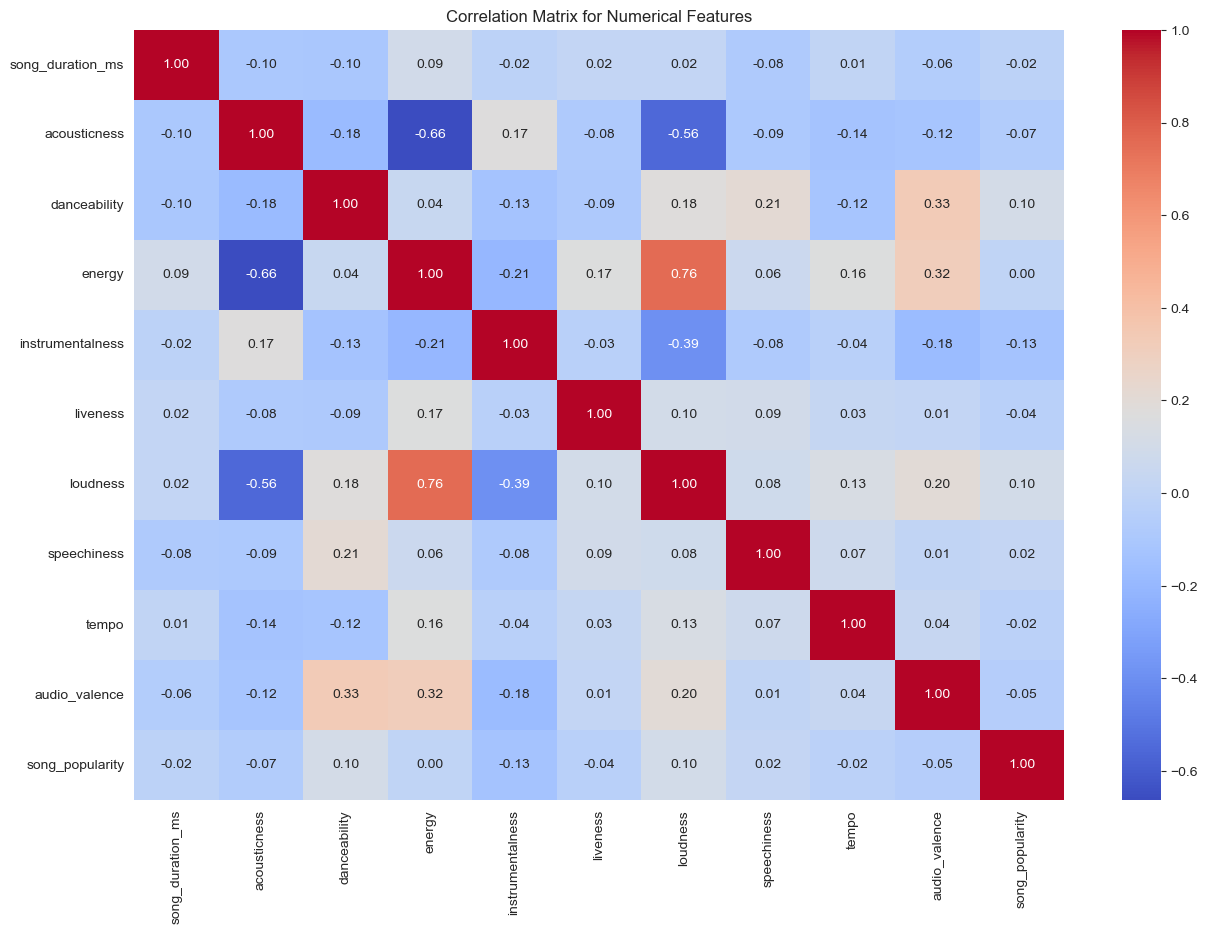

In [12]:
# Correlation Matrix
features_for_corr = numerical_features + [target]

plt.figure(figsize=(15, 10))
corr = df[features_for_corr].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Features')
plt.show()

**Multicollinearity nghiêm trọng:**
- `energy` - `loudness`: r=0.76 (tương quan mạnh) → có thể xem xét loại 1 trong 2.
- `acousticness` - `energy`: r=-0.66 (nghịch tương quan mạnh) → acousticness đối lập với energy
- `acousticness` - `loudness`: r=-0.56 → acousticness cũng tương quan âm với loudness
- `instrumentalness` - `loudness`: r=-0.39 → bài instrumental thường nhỏ hơn

**Tương quan với target (song_popularity):**
- Tất cả features có tương quan cực yếu với target (|r| < 0.15)
- Danceability: r=0.10, loudness: r=0.10 → tương quan dương mạnh nhất
- Instrumentalness: r=-0.13, acousticness: r=-0.07 → tương quan âm yếu

-> **VIF analysis cần thiết** để xác định chính xác features nào drop

-> Tương quan yếu xác nhận cần polynomial/interaction terms để cải thiện mô hình

# Data Preprocessing

In [13]:
# Filter errors based on domain knowledge

# Handle duplicates (as per your code)
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)

print(f"Shape after dropping duplicates: {df.shape}")

# Note
# All important value are within 0 and 1 range
# No missing value or invalid data detected in initial analysis

print("Initial shape:", df.shape)
# 1. Loudness must <= 0
df = df[df['loudness'] <= 0]

# 2. Tempo cant not be 0
df = df[df['tempo'] > 0]

# 3. Time Signature cant not be 0
df = df[df['time_signature'] > 0]

# 4. Filter out songs that are too short (e.g., < 30 seconds)
df = df[df['song_duration_ms'] >= 30000]

print(f"Shape after filtering errors: {df.shape}")

Shape after dropping duplicates: (14924, 14)
Initial shape: (14924, 14)
Shape after filtering errors: (14913, 14)


Từ các quan sát ở EDA:
- Kiểm tra một vài ràng buộc để đảm bảo dữ liệu chính xác
- Không có missing value và tồn tại nhiều duplicate

-> Xóa các duplicate

In [14]:
# Export cleaned datasets to csv files
df.to_csv('cleaned_song_data.csv', index=False)

In [15]:
# Split dataset into Train / Validate / Test set
X = df.drop(target, axis=1)
y = df[target]

# Split into Train / Test (85%, 15%)
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y,
    test_size=0.15,
    random_state=42
)

# Split into Train / Validate ~ (72%; 13%)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid,
    test_size=0.15,
    random_state=42
)

# Avoid SettingWithCopyWarning during preprocessing
X_train = X_train.copy()
X_valid = X_valid.copy()
X_test = X_test.copy()

total_len = len(X)
print(f"Total number of samples: {total_len}")
print(f"Train Set Samples: {len(X_train)} (~{len(X_train)/total_len*100:.2f}%)")
print(f"Validation Set Samples: {len(X_valid)} (~{len(X_valid)/total_len*100:.2f}%)")
print(f"Test Set Samples: {len(X_test)} (~{len(X_test)/total_len*100:.2f}%)")

Total number of samples: 14913
Train Set Samples: 10774 (~72.25%)
Validation Set Samples: 1902 (~12.75%)
Test Set Samples: 2237 (~15.00%)


Thực hiện chia 3 tập train, valid, test trước khi scale dữ liệu để đảm bảo không bị rò rỉ dữ liệu tập test

In [16]:
# Preprocessing
# Handle outliers using Log Transformation

# Log Transform for positive skewed columns
for col in ['song_duration_ms', 'liveness']:
    X_train[col] = np.log(X_train[col])
    X_valid[col] = np.log(X_valid[col])
    X_test[col] = np.log(X_test[col])

# Use Log1p Transform because 'speechiness' have zero values
X_train['speechiness'] = np.log1p(X_train['speechiness'])
X_valid['speechiness'] = np.log1p(X_valid['speechiness'])
X_test['speechiness'] = np.log1p(X_test['speechiness'])

# Handle lower outliers for 'loudness' using capping at 1st percentile
lower_cap_loudness = X_train['loudness'].quantile(0.01)

X_train['loudness'] = X_train['loudness'].clip(lower=lower_cap_loudness)
X_valid['loudness'] = X_valid['loudness'].clip(lower=lower_cap_loudness)
X_test['loudness'] = X_test['loudness'].clip(lower=lower_cap_loudness)

# Handle zero-inflated feature by creating binary features
X_train['is_instrumental'] = (X_train['instrumentalness'] > 0.5).astype(int)
X_valid['is_instrumental'] = (X_valid['instrumentalness'] > 0.5).astype(int)
X_test['is_instrumental'] = (X_test['instrumentalness'] > 0.5).astype(int)

# Drop the original column from all sets
X_train.drop('instrumentalness', axis=1, inplace=True)
X_valid.drop('instrumentalness', axis=1, inplace=True)
X_test.drop('instrumentalness', axis=1, inplace=True)

Tiếp theo cần xử lí các outliers, có rất nhiều feature xuất hiện outliers nên việc bỏ toàn bộ những outliers này làm mất rất nhiều dữ liệu, ta chọn các cách xử lí thích hợp tùy thuộc vào phân bố dữ liệu quan sát được từ EDA:
- Các feature song_duration, liveness, speechiness bị lệch trái khá mạnh

-> Dùng log transform để kéo cái outliers lại gần hơn với phần lớn dữ liệu còn lại (speechiness chứa các giá trị 0 nên dùng log1p)

- Loudness mang giá trị âm và lệch trái

-> Ở đây không dùng log transform vì vốn dĩ loudness đã là 1 thuộc tính log (dB). Ta chọn capping 1% dữ liệu bên trái để xử lí outliers

- Với instrumentaless, phần lớn dữ liệu là 0 và xấp xĩ 0 đã khiến đa số các giá trị còn lại biến thành outliers, capping sẽ bỏ qua các giá trị này trong khi chúng có thể cung cấp những thông tin hữu ích.

-> Ta biến feature này thành binary để giữ lại thông tin của cấc giá trị khác 0



In [17]:
# Encoding categorical features

# Pre shape
print(f"Original shapes:\nTrain={X_train.shape} \nValid={X_valid.shape} \nTest={X_test.shape}")

# audio_mode and new zero_inflated feature is binary, so we can skip it.
# Encode key and time_signature using dummy encoding

encode = ['key', 'time_signature']

# 1. Encode dataset independently
X_train = pd.get_dummies(X_train, columns=encode, drop_first=True)
X_valid = pd.get_dummies(X_valid, columns=encode, drop_first=True)
X_test = pd.get_dummies(X_test, columns=encode, drop_first=True)

# 2. Get master columns
# (Valid and test might not have the same columns with train so we will format them with train columns structure)
train_columns = X_train.columns

# 3. Format dataset with the master colums
X_valid = X_valid.reindex(columns=train_columns, fill_value=0)
X_test = X_test.reindex(columns=train_columns, fill_value=0)

# Post shape
print(f"Encoded shapes:\nTrain={X_train.shape} \nValid={X_valid.shape} \nTest={X_test.shape}")

Original shapes:
Train=(10774, 13) 
Valid=(1902, 13) 
Test=(2237, 13)
Encoded shapes:
Train=(10774, 25) 
Valid=(1902, 25) 
Test=(2237, 25)


Tiếp theo là xử lí nominal data, do là catagories nên các feature này sẽ gần như không tác động tuyến tính lên target là song_popularity. Do đó, ta cần encoding để xử lí riêng lẻ từng giá trị trong các catagories này.

Chọn dummy encoding vì:
- Tránh gây đa cộng tuyến như one-hot encoding
- Ở key ( Do, Re, Mi,...,Si, Do) có tính tuần hoàn nhưng việc sử dụng cylical encoding gây khó khăn cho việc diễn giải sau khi huấn luyện mô hình

# Multiple Linear Regression

Ta xây dựng mô hình MLR bằng 2 phương pháp chọn feature:
- Filter: Đánh giá độc lập các feature bằng mối tương quan của chúng với mục tiêu (song_population) và chọn ra những đặc trưng có tương quan mạnh mẽ nhất
    + Đánh giá khách quan các biến mà không nhìn vào kết quả mô hình -> Giảm một phần khả năng overfit
    + Giảm chi phí tính toán so với Wrapped
    + Chỉ sử dụng các phép biến đổi cơ bản ở bước preprocessing ở trên và xử lí đa cộng tuyến thủ công bằng việc tính giá trị VIF

-> Mô hình đảm bảo khả năng diễn giải do không thực hiện scale dữ liệu. Dùng làm baseline để đánh giá các mô hình khác.

- Wrapped (RLE): Tìm bộ feature mang kết quả tốt nhất
    + RLE đánh giá các feature thông qua hệ số góc nên cần scale dữ liệu trước khi huấn luyện -> Mất khả năng diễn giải
    + Đánh giá được sự tương tác giữa các feature, xây dựng được mô hình tối ưu trên tập train

-> Dùng để cố gắng xây dựng mô hình dự đoán kết quả chính xác khi dùng OLS

In [18]:
# Store all model results
all_model_results = []

- We will build some code for Regression Diagnostics

In [19]:
def plot_regression_diagnostics(model, X_data, y_true, name='Model'):
    """
    Vẽ biểu đồ Predicted vs. Actual để đánh giá nhanh hiệu suất.
    """
    y_pred = model.predict(X_data)

    _, ax = plt.subplots(figsize=(7, 6))
    
    ax.scatter(y_true, y_pred, alpha=0.6)
    perfect_line = np.linspace(min(y_true.min(), y_pred.min()), 
                               max(y_true.max(), y_pred.max()), 
                               100)
    ax.plot(perfect_line, perfect_line, color='r', linestyle='--', label='Perfected fit (y=x)')
    
    ax.set_title(f'Predicted vs. Actual Values\n({name})', fontsize=16)
    ax.set_xlabel('Actual Values ($y_{true}$)', fontsize=12)
    ax.set_ylabel('Predicted Values ($y_{pred}$)', fontsize=12)
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# Mô hình 1: OLS + Filter
- Loại các biến có Variance inflation factor (VIF) cao

In [20]:
X_train1 = X_train.copy()
X_valid1 = X_valid.copy()
X_test1 = X_test.copy()

In [21]:
# VIF Calculation

bool_cols = X_train1.select_dtypes(include=['bool']).columns
if not bool_cols.empty:
    X_train1[bool_cols] = X_train1[bool_cols].astype(int)

X_with_const = add_constant(X_train1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train1.columns

vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(len(X_train1.columns))]

print(vif_data.sort_values(by='VIF', ascending=False))

             feature        VIF
23  time_signature_4  13.226527
22  time_signature_3  10.591977
3             energy   3.968958
24  time_signature_5   3.802955
5           loudness   3.035752
1       acousticness   2.100887
11             key_1   1.756347
17             key_7   1.736254
19             key_9   1.671248
21            key_11   1.641319
12             key_2   1.638316
15             key_5   1.600812
14             key_4   1.540042
20            key_10   1.535481
16             key_6   1.533292
18             key_8   1.505666
2       danceability   1.464732
9      audio_valence   1.407291
13             key_3   1.233226
10   is_instrumental   1.209372
7        speechiness   1.139922
6         audio_mode   1.110958
0   song_duration_ms   1.077773
8              tempo   1.074586
4           liveness   1.061798


*Note: Dữ liệu time signature trước khi encoding bị lệch nặng (giá trị 4 chiếm tới hơn 90%), dẫn đến sau khi dùng dummy encoding giá trị VIF của các biến mới có VIF rất cao dù đã dropFirst

-> Drop cột time_signature_4

energy là biến numeric có VIF cao nhất (như corr_matrix trên thì tương quan cao với loudness)

-> Drop energy

In [22]:
# VIF Calculation
X_train1 = X_train1.drop(['time_signature_4', 'energy'], axis=1)
X_valid1 = X_valid1.drop(['time_signature_4', 'energy'], axis=1)
X_test1 = X_test1.drop(['time_signature_4', 'energy'], axis=1)

bool_cols = X_train1.select_dtypes(include=['bool']).columns
if not bool_cols.empty:
    X_train1[bool_cols] = X_train1[bool_cols].astype(int)

X_with_const = add_constant(X_train1)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train1.columns

vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(len(X_train1.columns))]

print(vif_data.sort_values(by='VIF', ascending=False))

             feature       VIF
10             key_1  1.756336
4           loudness  1.753041
16             key_7  1.736245
18             key_9  1.671119
1       acousticness  1.643489
20            key_11  1.641278
11             key_2  1.637473
14             key_5  1.600781
13             key_4  1.539397
19            key_10  1.535282
15             key_6  1.532517
17             key_8  1.505597
2       danceability  1.347439
12             key_3  1.232940
8      audio_valence  1.207245
9    is_instrumental  1.177030
6        speechiness  1.134064
5         audio_mode  1.110891
21  time_signature_3  1.081757
7              tempo  1.071530
0   song_duration_ms  1.069776
3           liveness  1.052531
22  time_signature_5  1.026915


Sau khi drop cột time_signature_4 và energy, VIF giờ đã nằm ở mức ổn

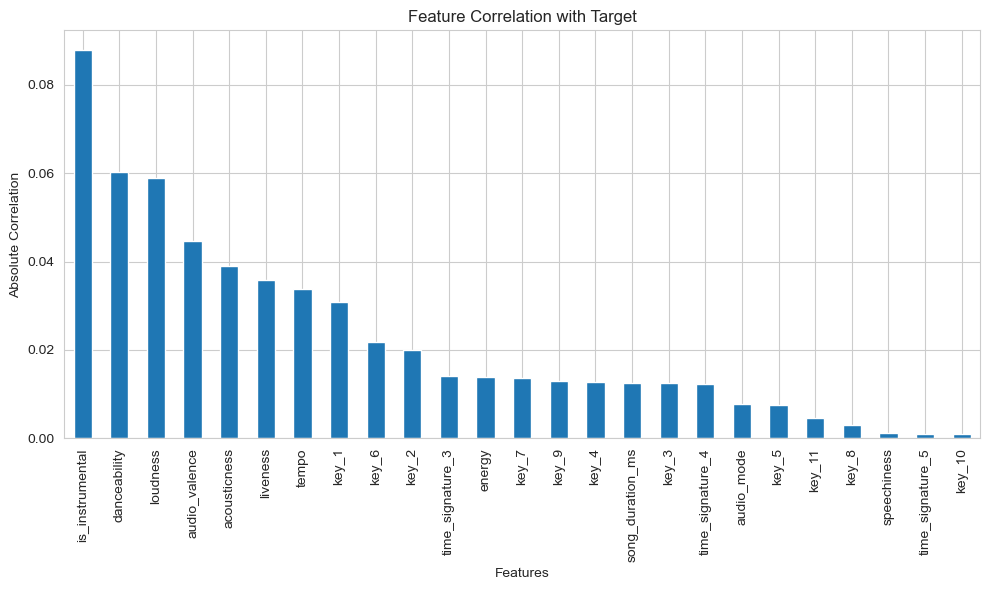

In [23]:
correlations = X_train.corrwith(y_train)

# Lấy trị tuyệt đối và sắp xếp giảm dần
corr_sorted = correlations.abs().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
corr_sorted.plot(kind='bar')
plt.title('Feature Correlation with Target')
plt.ylabel('Absolute Correlation')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

- Tất cả các hệ số tương quan đều ở mức thấp
- Khả năng dự đoán của mô hình có thể nằm ở sự kết hợp giữa các đặc trưng
- Việc đặt một ngưỡng để loại bỏ các đặc trưng yếu có thể làm mất đi các đặc trưng quan trọng khi kết hợp
- Mô hình được xây dựng ưu tiên khả năng diễn giải nên độ phức tạp không quá quan trọng

-> Ta chọn giữ nguyên các đặc trưng sau khi đã qua bước lọc VIF. Xây dựng mô hình OLS cơ bản này như baseline để so sánh với các mô hình sau

Intercept: 51.566231

Coefficients:
  song_duration_ms: -0.163455
  acousticness: -0.565997
  danceability: 8.914736
  liveness: -1.082037
  loudness: 0.215030
  audio_mode: 0.786059
  speechiness: -4.540759
  tempo: -0.019200
  audio_valence: -7.404361
  is_instrumental: -5.837601
  key_1: 1.031409
  key_2: -1.337227
  key_3: -0.762305
  key_4: -0.706514
  key_5: 0.656653
  key_6: 1.494968
  key_7: -0.745276
  key_8: -0.068527
  key_9: -0.659480
  key_10: 0.208005
  key_11: 0.281103
  time_signature_3: 0.398884
  time_signature_5: 1.451129

R² Score (Train): 0.022332
R² Score (Valid): 0.022897

RMSE (Train): 20.107646
RMSE (Valid): 20.332544

MAE (Train): 15.996777
MAE (Valid): 16.349100


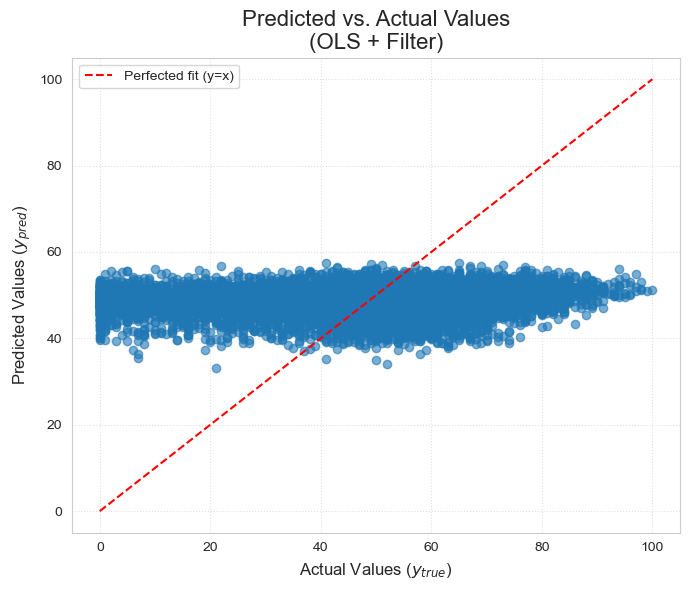

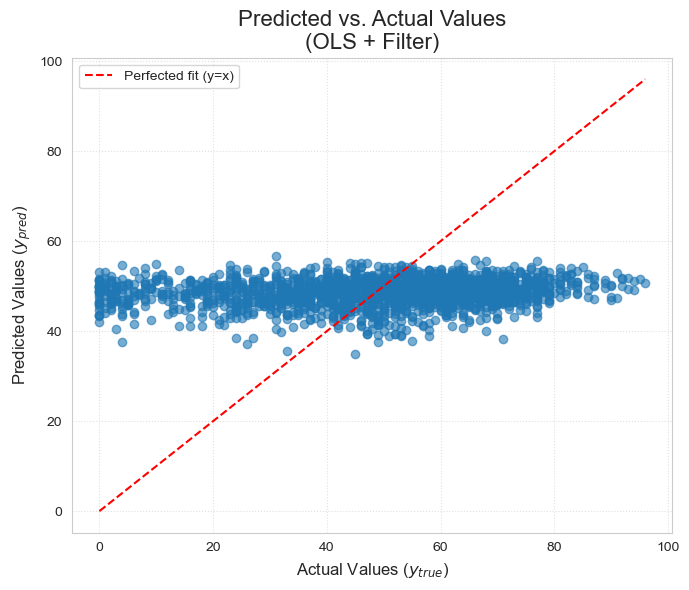

In [24]:
# Model 1 Training

# Train the model
model1 = LinearRegression()
model1.fit(X_train1, y_train)

# Make predictions
y_train_pred1 = model1.predict(X_train1)
y_valid_pred1 = model1.predict(X_valid1)

print(f"Intercept: {model1.intercept_:.6f}")
print(f"\nCoefficients:")
for feature, coef in zip(X_train1.columns, model1.coef_):
    print(f"  {feature}: {coef:.6f}")
print(f"\nR² Score (Train): {r2_score(y_train, y_train_pred1):.6f}")
print(f"R² Score (Valid): {r2_score(y_valid, y_valid_pred1):.6f}")
print(f"\nRMSE (Train): {np.sqrt(mean_squared_error(y_train, y_train_pred1)):.6f}")
print(f"RMSE (Valid): {np.sqrt(mean_squared_error(y_valid, y_valid_pred1)):.6f}")
print(f"\nMAE (Train): {mean_absolute_error(y_train, y_train_pred1):.6f}")
print(f"MAE (Valid): {mean_absolute_error(y_valid, y_valid_pred1):.6f}")

# cHeck diagnostics
plot_regression_diagnostics(model1, X_train1, y_train, 'OLS + Filter')
plot_regression_diagnostics(model1, X_valid1, y_valid, 'OLS + Filter')

all_model_results.append({
    'Model': 'OLS + Filter',
    'R² (Valid)': r2_score(y_valid, y_valid_pred1),
    'RMSE (Valid)': np.sqrt(mean_squared_error(y_valid, y_valid_pred1)),
    'MAE (Valid)': mean_absolute_error(y_valid, y_valid_pred1),
    'Estimator': model1,
    'Input_Type': 'X_test1'
})

**Hiệu suất:**
- R² chỉ 2.3% → mô hình gần như không giải thích được gì
- RMSE ~20.3 trên thang 0-100
- Hiệu suất cực kỳ yếu

**Predicted vs Actual plots:**
- Tất cả predictions tập trung thành đám mây ngang ở 40-55 (gần mean)
- Không bám theo đường chéo đỏ lý tưởng
- Mô hình chỉ dự đoán constant value, không phân biệt được bài hát phổ biến hay không

**Kết luận:**
- Các features có tương quan quá yếu với target
- OLS tuyến tính đơn giản không đủ để capture mối quan hệ phức tạp
- Đây là baseline để so sánh với các mô hình sau

# Mô hình 2: OLS + Wrapper (RLE)

- Scale before training

In [25]:
X_train2 = X_train.copy()
X_valid2 = X_valid.copy()
X_test2 = X_test.copy()

# Feature Scaling using Robust Scaler
# We dont scale the dummy and binary features
binary_and_dummy = [col for col in X_train.columns if col.startswith('key_') or col.startswith('time_signature_')] + ['audio_mode', 'is_instrumental']

# Extract numerical columns to scale
cols_to_scale = [col for col in X_train.select_dtypes(include=['number']).columns if col not in binary_and_dummy]


# Fit the train set
scaler = RobustScaler()
X_train2[cols_to_scale] = scaler.fit_transform(X_train2[cols_to_scale])

# 3. Transform the validation and test sets
X_valid2[cols_to_scale] = scaler.transform(X_valid2[cols_to_scale])
X_test2[cols_to_scale] = scaler.transform(X_test2[cols_to_scale])

Selected features (17):
['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'audio_mode', 'tempo', 'audio_valence', 'is_instrumental', 'key_1', 'key_2', 'key_3', 'key_4', 'key_6', 'key_7', 'key_9', 'time_signature_5']
Intercept: 49.794670

Coefficients:
  acousticness: -1.544718
  danceability: 1.231140
  energy: -3.686019
  liveness: -0.826030
  loudness: 2.598958
  audio_mode: 0.803720
  tempo: -0.777661
  audio_valence: -1.980273
  is_instrumental: -5.061282
  key_1: 0.735285
  key_2: -1.446268
  key_3: -0.981183
  key_4: -0.787945
  key_6: 1.369993
  key_7: -0.951346
  key_9: -0.821284
  time_signature_5: 0.880851

R² Score (Train): 0.025945
R² Score (Valid): 0.026506

RMSE (Train): 20.070461
RMSE (Valid): 20.294966

MAE (Train): 15.973574
MAE (Valid): 16.313427


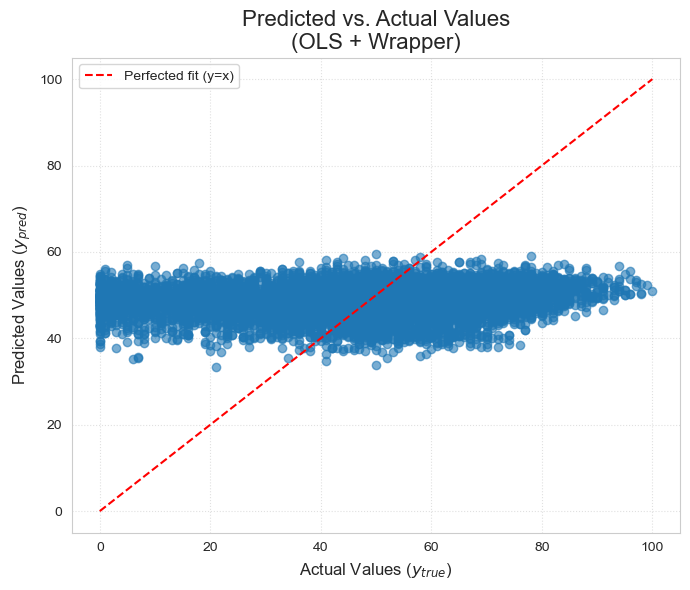

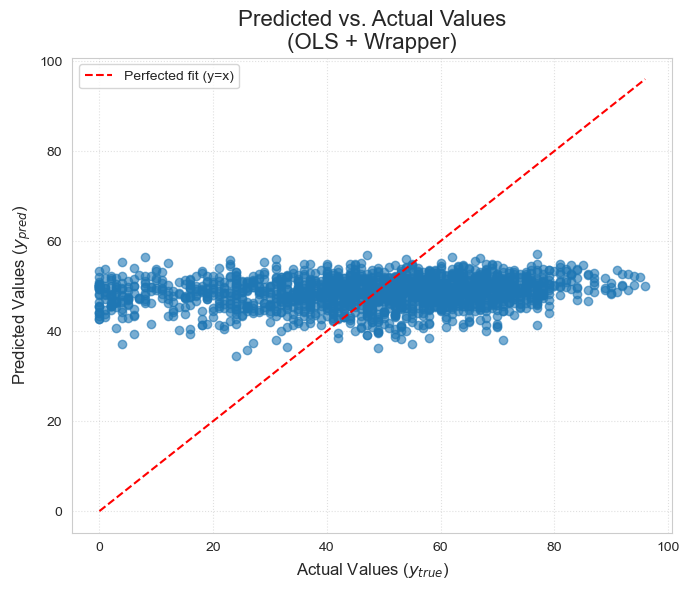

In [26]:
# Model 2 Training

# Use LinearRegression with RFE to select best features
n_features_to_select = 17
lr_model = LinearRegression()

# Create RFE selector with LinearRegression
rfe = RFE(estimator=lr_model, n_features_to_select=n_features_to_select, step=1)
rfe.fit(X_train2, y_train)

# Get selected features
selected_features = X_train2.columns[rfe.support_].tolist()
print(f"Selected features ({len(selected_features)}):")
print(selected_features)

# Prepare data with selected features only
X_train2_selected = X_train2[selected_features]
X_valid2_selected = X_valid2[selected_features]

# Train final model with selected features
model2 = LinearRegression()
model2.fit(X_train2_selected, y_train)

# Make predictions
y_train_pred2 = model2.predict(X_train2_selected)
y_valid_pred2 = model2.predict(X_valid2_selected)

print(f"Intercept: {model2.intercept_:.6f}")
print(f"\nCoefficients:")
for feature, coef in zip(selected_features, model2.coef_):
    print(f"  {feature}: {coef:.6f}")
print(f"\nR² Score (Train): {r2_score(y_train, y_train_pred2):.6f}")
print(f"R² Score (Valid): {r2_score(y_valid, y_valid_pred2):.6f}")
print(f"\nRMSE (Train): {np.sqrt(mean_squared_error(y_train, y_train_pred2)):.6f}")
print(f"RMSE (Valid): {np.sqrt(mean_squared_error(y_valid, y_valid_pred2)):.6f}")
print(f"\nMAE (Train): {mean_absolute_error(y_train, y_train_pred2):.6f}")
print(f"MAE (Valid): {mean_absolute_error(y_valid, y_valid_pred2):.6f}")

# check diagnostics
plot_regression_diagnostics(model2, X_train2_selected, y_train, 'OLS + Wrapper')
plot_regression_diagnostics(model2, X_valid2_selected, y_valid, 'OLS + Wrapper')

all_model_results.append({
    'Model': 'OLS + Wrapper',
    'R² (Valid)': r2_score(y_valid, y_valid_pred2),
    'RMSE (Valid)': np.sqrt(mean_squared_error(y_valid, y_valid_pred2)),
    'MAE (Valid)': mean_absolute_error(y_valid, y_valid_pred2),
    'Estimator': model2,
    'Input_Type': 'X_test_RFE'
})

**Hiệu suất:**
- R² tăng lên 2.65% (từ 2.3% ở Model 1)
- RMSE ~20.29, cải thiện nhẹ so với baseline
- Vẫn cực kỳ yếu

**RFE Feature Selection:**
- RFE chọn 17/23 features, loại 6 features yếu nhất
- Giữ lại: acousticness, danceability, energy, loudness, tempo, valence, is_instrumental, một số key và time_signature_5
- Scaling được áp dụng → mất khả năng diễn giải so với Model 1

**Predicted vs Actual plots:**
- Tương tự Model 1: đám mây ngang 40-55, không bám theo đường chéo
- Mô hình vẫn chỉ dự đoán constant gần mean

**Kết luận:**
- RFE cải thiện nhẹ nhưng vẫn không đủ
- Feature selection không giải quyết được vấn đề tương quan yếu với target
- Cần phương pháp phức tạp hơn (polynomial) để capture non-linear relationships

# Mô hình 3: OLS + Polynomial

- Polynomial with features choosing from RFE previously

Selected features (17):
['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'audio_mode', 'tempo', 'audio_valence', 'is_instrumental', 'key_1', 'key_2', 'key_3', 'key_4', 'key_6', 'key_7', 'key_9', 'time_signature_5']
Best parameters: {'poly__degree': 2}
Number of features after polynomial expansion: 170
R² Score (Train): 0.060886
R² Score (Valid): 0.044154
RMSE (Train): 19.707192
RMSE (Valid): 20.110165
MAE (Train): 15.605965
MAE (Valid): 16.093489
Best parameters: {'poly__degree': 2}
Number of features after polynomial expansion: 170
R² Score (Train): 0.060886
R² Score (Valid): 0.044154
RMSE (Train): 19.707192
RMSE (Valid): 20.110165
MAE (Train): 15.605965
MAE (Valid): 16.093489


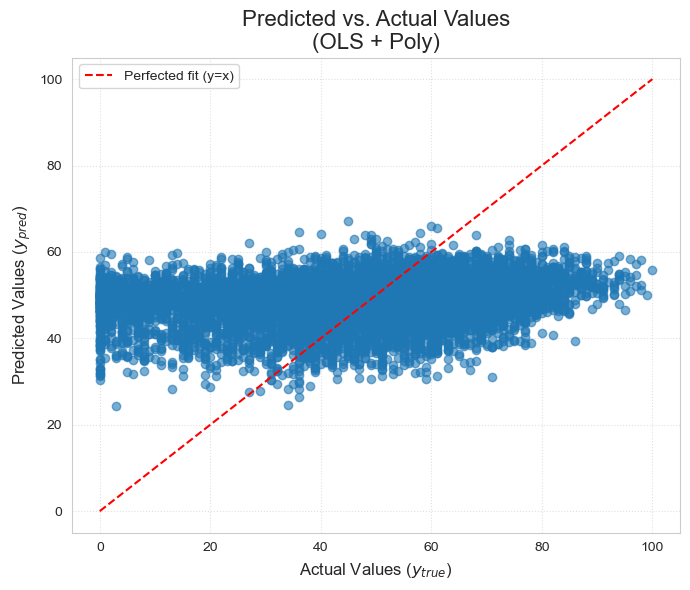

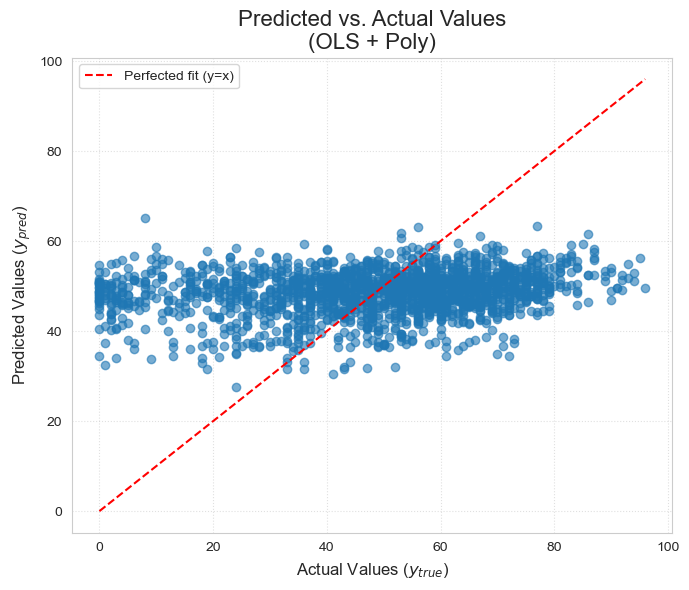

In [27]:
# Use the features selected from RFE in Model 2
X_train3 = X_train2[selected_features].copy()
X_valid3 = X_valid2[selected_features].copy()
print(f"Selected features ({len(selected_features)}):")
print(selected_features)

# Create pipeline for polynomial features and scaling
pipePoly = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', RobustScaler()),
    ('model', LinearRegression())
])

# parameter grid for GridSearchCV
degree = {'poly__degree': [2,3]}

# perform grid search with cross-validation
searchPoly = GridSearchCV(pipePoly, param_grid=degree, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
searchPoly.fit(X_train3, y_train)

# best parameters
print(f"Best parameters: {searchPoly.best_params_}")
best_model = searchPoly.best_estimator_

# Number of features after polynomial expansion
poly_features = best_model.named_steps['poly'].get_feature_names_out(input_features=selected_features)
print(f"Number of features after polynomial expansion: {len(poly_features)}")

# Make predictions
y_train_pred3 = searchPoly.predict(X_train3)
y_valid_pred3 = searchPoly.predict(X_valid3)

# Evaluate the model
print(f"R² Score (Train): {r2_score(y_train, y_train_pred3):.6f}")
print(f"R² Score (Valid): {r2_score(y_valid, y_valid_pred3):.6f}")
print(f"RMSE (Train): {np.sqrt(mean_squared_error(y_train, y_train_pred3)):.6f}")
print(f"RMSE (Valid): {np.sqrt(mean_squared_error(y_valid, y_valid_pred3)):.6f}")
print(f"MAE (Train): {mean_absolute_error(y_train, y_train_pred3):.6f}")
print(f"MAE (Valid): {mean_absolute_error(y_valid, y_valid_pred3):.6f}")

# check diagnostics
plot_regression_diagnostics(best_model, X_train3, y_train, 'OLS + Poly')
plot_regression_diagnostics(best_model, X_valid3, y_valid, 'OLS + Poly')

all_model_results.append({
    'Model': f'OLS + Poly (deg={searchPoly.best_params_["poly__degree"]})',
    'R² (Valid)': r2_score(y_valid, y_valid_pred3),
    'RMSE (Valid)': np.sqrt(mean_squared_error(y_valid, y_valid_pred3)),
    'MAE (Valid)': mean_absolute_error(y_valid, y_valid_pred3),
    'Estimator': best_model,
    'Input_Type': 'X_test_RFE'
})

**Hiệu suất:**
- R² nhảy vọt lên 4.4% (gấp đôi so với Model 2)
- RMSE ~20.11, cải thiện rõ rệt
- Vẫn còn yếu nhưng bước tiến đáng kể

**Polynomial Features:**
- Degree=2 được chọn (degree=3 bị loại do overfitting)
- Tạo 170 features từ 17 RFE features ban đầu
- Capture được non-linear relationships giữa các features
- Có dấu hiệu overfitting nhẹ (R² train 6.1% vs valid 4.4%)

**Predicted vs Actual plots:**
- Phân bố rộng hơn, không còn đám mây ngang hoàn toàn
- Bắt đầu có xu hướng dọc theo đường chéo nhưng vẫn rất yếu
- Mô hình bắt đầu phân biệt được popularity ở mức độ nhất định

**Kết luận:**
- Polynomial features là bước đột phá quan trọng nhất
- Xác nhận dữ liệu có mối quan hệ phi tuyến (quadratic)
- OLS không kiểm soát được multicollinearity của polynomial terms
- Cần regularization (Ridge/Lasso) để ổn định và cải thiện thêm

# Mô hình 4: Polynomial with Ridge Regression

- Polynomial shows overfitting at high degree, so we try Ridge regression (Sum of squared regulization method) to solve the overfitting problem
- We still use RFE selected features from Model 2 to see if Ridge can improve the accuracy by handling multicollinearity

Best parameters: {'poly__degree': 2, 'ridge__alpha': 100.0}

R² Score (Train): 0.058983
R² Score (Valid): 0.046641

RMSE (Train): 19.727144
RMSE (Valid): 20.083982

MAE (Train): 15.621156
MAE (Valid): 16.077340


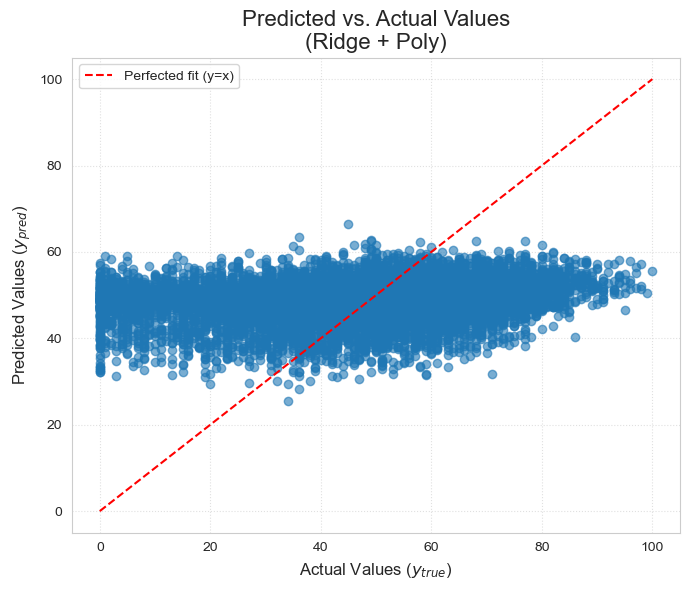

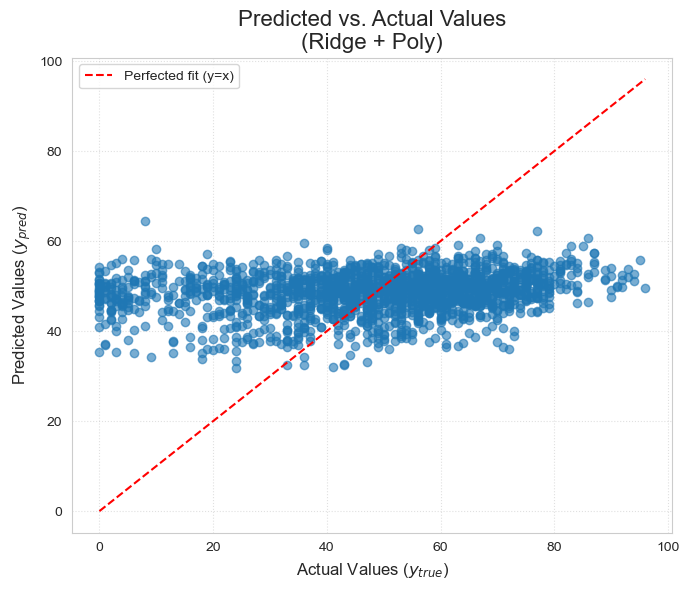

In [28]:
X_train4 = X_train3.copy()
X_valid4 = X_valid3.copy()

# Create a pipeline
pipeRidge = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', RobustScaler()),
    ('ridge', Ridge())
])

# Define parameter for GridSearchCV
paramRidge = {
    'poly__degree': [2, 3],
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0]
}

# Perform parameter tuning with Cross-Validation
searchRidge = GridSearchCV(pipeRidge, paramRidge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # MAKE SURE YOUR CPU AND RAM CAN HANDLE n_jobs=-1
searchRidge.fit(X_train4, y_train)

# Best parameters
print(f"Best parameters: {searchRidge.best_params_}")
best_model_ridge = searchRidge.best_estimator_

# Make predictions
y_train_pred4 = best_model_ridge.predict(X_train4)
y_valid_pred4 = best_model_ridge.predict(X_valid4)

# Evaluate the model
print(f"\nR² Score (Train): {r2_score(y_train, y_train_pred4):.6f}")
print(f"R² Score (Valid): {r2_score(y_valid, y_valid_pred4):.6f}")
print(f"\nRMSE (Train): {np.sqrt(mean_squared_error(y_train, y_train_pred4)):.6f}")
print(f"RMSE (Valid): {np.sqrt(mean_squared_error(y_valid, y_valid_pred4)):.6f}")
print(f"\nMAE (Train): {mean_absolute_error(y_train, y_train_pred4):.6f}")
print(f"MAE (Valid): {mean_absolute_error(y_valid, y_valid_pred4):.6f}")

# check diagnostics
plot_regression_diagnostics(best_model_ridge, X_train4, y_train, 'Ridge + Poly')
plot_regression_diagnostics(best_model_ridge, X_valid4, y_valid, 'Ridge + Poly')

all_model_results.append({
    'Model': f'Ridge + Poly (deg={searchRidge.best_params_["poly__degree"]})',
    'R² (Valid)': r2_score(y_valid, y_valid_pred4),
    'RMSE (Valid)': np.sqrt(mean_squared_error(y_valid, y_valid_pred4)),
    'MAE (Valid)': mean_absolute_error(y_valid, y_valid_pred4),
    'Estimator': best_model_ridge,
    'TestData_Input': 'X_test_RFE'
})

**Hiệu suất:**
- R² tăng lên 4.66% (cao hơn Model 3: 4.4%)
- RMSE ~20.08, tốt nhất cho đến giờ
- Ổn định hơn Model 3 (R² train 5.9% vs valid 4.66%, gap nhỏ hơn)

**Ridge Regularization:**
- Degree=2, alpha=100.0 (penalty rất cao)
- Alpha cao chứng tỏ polynomial features có multicollinearity nghiêm trọng
- L2 penalty shrink coefficients, giảm overfitting so với Model 3
- Giữ tất cả 170 polynomial features nhưng giảm ảnh hưởng của features yếu

**Predicted vs Actual plots:**
- Tương tự Model 3, phân bố rộng hơn baseline
- Ổn định hơn Model 3 một chút, ít biến động hơn
- Vẫn chưa bám sát đường chéo

**Kết luận:**
- Ridge thành công kiểm soát overfitting của polynomial
- Cải thiện nhẹ nhưng đáng kể so với OLS + Poly
- L2 penalty hiệu quả với multicollinearity
- Tuy nhiên, tốc độ huấn luyện bị chậm lại một tí

# Mô hình 5: Polynomial with Lasso Regression

- We use Lasso (Sum of absolute regulization method) on the original (Scaled) dataset, allowing the Lasso model (L1 feature selection) to analyze all features.

Best parameters: {'lasso__alpha': 0.1, 'poly__degree': 2}
Number of features removed by Lasso: 293 / 350
Number of features used by Lasso: 57 / 350

R² Score (Train): 0.053915
R² Score (Valid): 0.048092

RMSE (Train): 19.780195
RMSE (Valid): 20.068696

MAE (Train): 15.650142
MAE (Valid): 16.025193


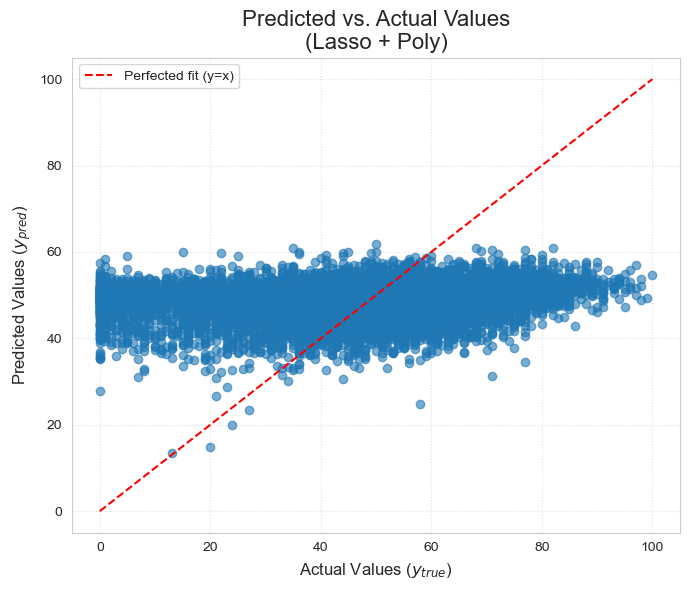

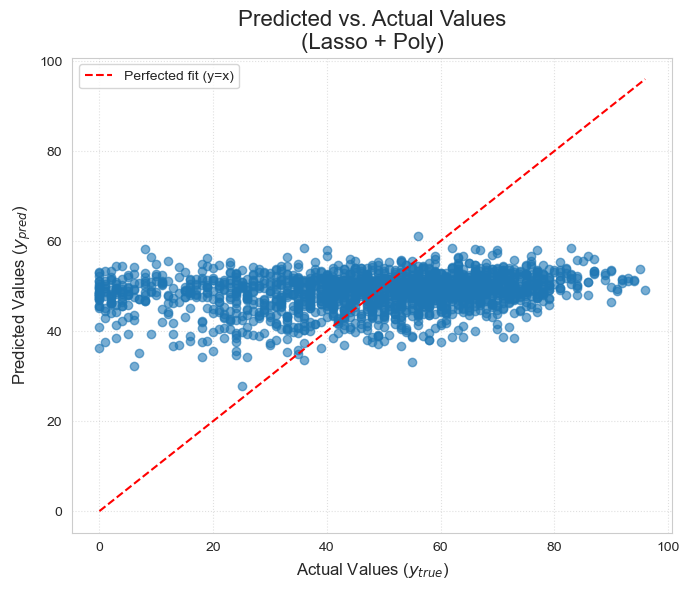

In [ ]:
# We wont use the RFE selected features here. We will let it select by Lasso itself

# We will use all features from scaled dataset (X_train2, X_valid2)
# We scale numerical features BEFORE PolynomialFeatures to prevent the scale of new features 
# from exploding, which helps the Lasso model perform better.
X_train5 = X_train2.copy()
X_valid5 = X_valid2.copy()

# Create a pipeline
pipeLasso = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', RobustScaler()),
    ('lasso', Lasso(max_iter=10000))
])

# Define parameter for GridSearchCV
paramLasso = {
    'poly__degree': [2,3],
    'lasso__alpha': [0.01, 0.1, 1.0, 10.0] # Lasso is more sensitive to alpha
}

# Perform parameter tuning with Cross-Validation
searchLasso = GridSearchCV(pipeLasso, paramLasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1) # MAKE SURE YOUR CPU AND RAM CAN HANDLE n_jobs=-1
searchLasso.fit(X_train5, y_train)

# Best parameters
print(f"Best parameters: {searchLasso.best_params_}")
best_model_lasso = searchLasso.best_estimator_

# Number of features removed by Lasso
lasso_coef = best_model_lasso.named_steps['lasso'].coef_
num_features_removed = np.sum(lasso_coef == 0)
print(f"Number of features removed by Lasso: {num_features_removed} / {len(lasso_coef)}")
print(f"Number of features used by Lasso: {len(lasso_coef) - num_features_removed} / {len(lasso_coef)}")

# Make predictions
y_train_pred5 = best_model_lasso.predict(X_train5)
y_valid_pred5 = best_model_lasso.predict(X_valid5)

# Evaluate the model
print(f"\nR² Score (Train): {r2_score(y_train, y_train_pred5):.6f}")
print(f"R² Score (Valid): {r2_score(y_valid, y_valid_pred5):.6f}")
print(f"\nRMSE (Train): {np.sqrt(mean_squared_error(y_train, y_train_pred5)):.6f}")
print(f"RMSE (Valid): {np.sqrt(mean_squared_error(y_valid, y_valid_pred5)):.6f}")
print(f"\nMAE (Train): {mean_absolute_error(y_train, y_train_pred5):.6f}")
print(f"MAE (Valid): {mean_absolute_error(y_valid, y_valid_pred5):.6f}")

# check diagnostics
plot_regression_diagnostics(best_model_lasso, X_train5, y_train, 'Lasso + Poly')
plot_regression_diagnostics(best_model_lasso, X_valid5, y_valid, 'Lasso + Poly')

all_model_results.append({
    'Model': f'Lasso + Poly (deg={searchLasso.best_params_["poly__degree"]})',
    'R² (Valid)': r2_score(y_valid, y_valid_pred5),
    'RMSE (Valid)': np.sqrt(mean_squared_error(y_valid, y_valid_pred5)),
    'MAE (Valid)': mean_absolute_error(y_valid, y_valid_pred5),
    'Estimator': best_model_lasso,
    'TestData_Input': 'X_test_All'
})

**Hiệu suất:**
- R² 4.81%, cao nhất trong tất cả models
- RMSE 20.069, tốt nhất (thấp nhất)
- Ổn định tốt (R² train 5.4% vs valid 4.81%)

**Lasso Feature Selection:**
- Degree=2 vẫn cho kết quả tốt nhất. Degree=3 có thể bị overfitting nậng.
- alpha=0.1 cao, cho thấy Lasso đã loại đi rất nhiều biến không hữu dụng.
- L1 penalty loại bỏ 293/350 features (84%), chỉ giữ 57 features quan trọng
- Sử dụng tất cả 23 features ban đầu (không qua RFE) cho phép Lasso tự chọn ra features tốt hơn RFE thủ công.

**Predicted vs Actual plots:**
- Tương tự các polynomial models khác
- Phân bố rộng, bắt đầu có trend dọc nhưng vẫn yếu
- Ổn định và consistent

**Kết luận:**
- Best model: Lasso + Poly vượt trội nhờ feature selection tự động
- L1 penalty vừa regularize vừa xoá features dư thừa
- Giải thích được 4.8% variance - vẫn rất thấp, 95.2% không giải thích được

-> Linear methods (kể cả quadratic) không đủ cho dữ liệu này

-> Cần non-linear models (Tree-based, Neural Networks) để cải thiện đáng kể

# Đánh giá

In [30]:
if not all_model_results:
    print("ERROR: 'all_model_results' list is empty.")
else:
    # 2. Create DataFrame and sort by best RMSE
    results_df = pd.DataFrame(all_model_results)
    results_df = results_df.set_index('Model')
    results_df = results_df.sort_values(by='RMSE (Valid)', ascending=True)

    # Display the results
    print(results_df[['R² (Valid)', 'RMSE (Valid)', 'MAE (Valid)']].to_string(float_format='{:.6f}'.format))

    # 4. Get the best model and its info
    best_model_name = results_df.index[0]
    best_model_row = results_df.iloc[0]
    best_estimator = best_model_row['Estimator']
    best_model_input_type = best_model_row['TestData_Input']

    print(f"\n Best Model: {best_model_name} (RMSE: {best_model_row['RMSE (Valid)']:.6f})")

                      R² (Valid)  RMSE (Valid)  MAE (Valid)
Model                                                      
Lasso + Poly (deg=2)    0.048092     20.068696    16.025193
Ridge + Poly (deg=2)    0.046641     20.083982    16.077340
OLS + Poly (deg=2)      0.044154     20.110165    16.093489
OLS + Wrapper           0.026506     20.294966    16.313427
OLS + Filter            0.022897     20.332544    16.349100

 Best Model: Lasso + Poly (deg=2) (RMSE: 20.068696)


Best model: **Lasso + Poly (deg=2)** với RMSE=20.069 (thấp nhất)

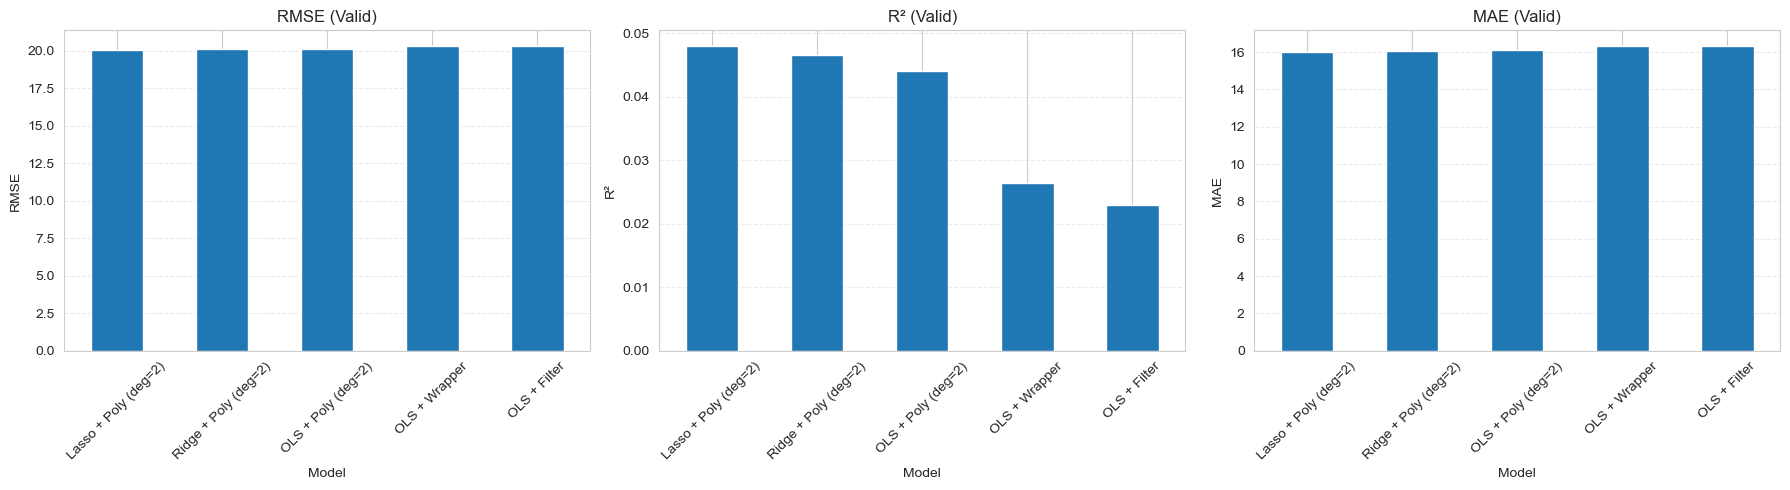

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- RMSE ---
results_df['RMSE (Valid)'].plot(kind='bar', ax=axes[0])
axes[0].set_title('RMSE (Valid)')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

# --- R2 ---
results_df['R² (Valid)'].plot(kind='bar', ax=axes[1])
axes[1].set_title('R² (Valid)')
axes[1].set_ylabel('R²')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

# --- MAE ---
results_df['MAE (Valid)'].plot(kind='bar', ax=axes[2])
axes[2].set_title('MAE (Valid)')
axes[2].set_ylabel('MAE')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

**RMSE (Valid):**
- Models 1,2 (OLS): RMSE cao (~20.29-20.33), kém nhất
- Model 3 (OLS+Poly): RMSE giảm xuống 20.11, cải thiện đầu tiên
- Models 4,5 (Ridge/Lasso): RMSE tiếp tục giảm, Lasso 20.069 thấp nhất
- **Gap nhỏ giữa các models** (0.26 điểm) → tất cả đều yếu tương đương

**R² (Valid):**
- Models 1,2: R² ~2.3-2.6% - gần như không giải thích được gì
- Model 3: R² nhảy lên 4.4% - **bước tiến lớn** nhờ polynomial
- Models 4,5: R² ~4.6-4.8%, cải thiện nhẹ nhờ regularization
- **Tất cả < 5%**: Linear methods thất bại hoàn toàn với dữ liệu này

**MAE (Valid):**
- Pattern tương tự RMSE
- Lasso có MAE=16.025 thấp nhất
- Gap giữa các models rất nhỏ (~0.3 điểm)

**Kết luận chính:**
- **Polynomial (degree=2) là game-changer**: Model 3 tạo bước nhảy lớn nhất từ 2.6% lên 4.4%
- **Regularization giúp ổn định nhưng không đột phá**: Ridge/Lasso chỉ cải thiện thêm 0.2-0.4%
- **Tất cả models đều yếu**: Ngay cả best model chỉ giải thích 4.8% variance

**Kết luận về đặc điểm dữ liệu:**

*Tính chất data:*
- Correlation yếu (|r| < 0.15)
- Không có linear/quadratic patterns → mối quan hệ phức tạp
- External noise cao → popularity phụ thuộc nhiều hơn chỉ audio features.
- Highly non-linear với complex interactions → vượt khả năng linear models

# Exploration and Key insight for the best model

C:\Users\tinti\AppData\Local\Temp\ipykernel_3472\3115200622.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis', legend=False)


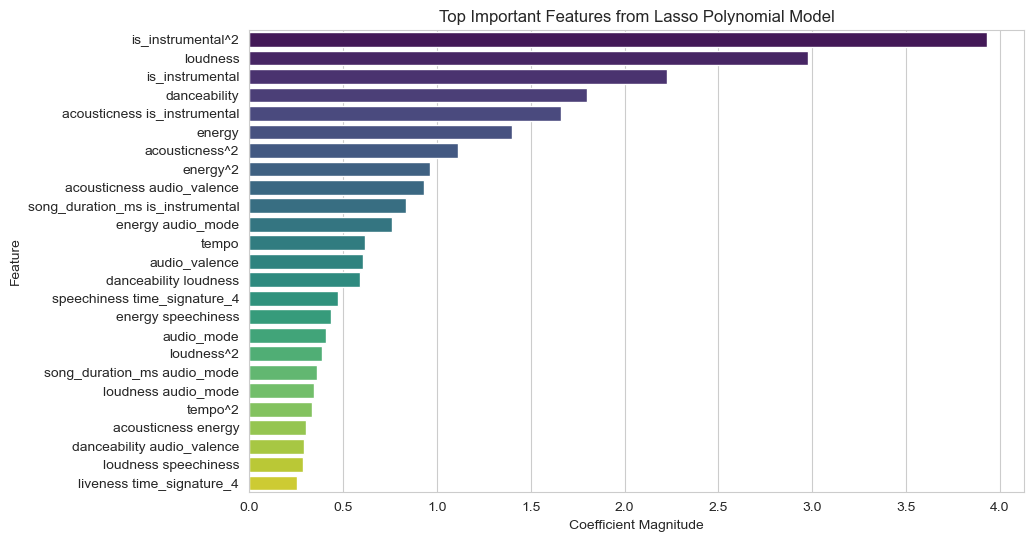

In [32]:
# Analyze the best model
poly_features = best_estimator.named_steps['poly']
lasso_model = best_estimator.named_steps['lasso']
    
features = X_train5.columns
feature_names = poly_features.get_feature_names_out(features)
coef = lasso_model.coef_

# VISUALIZE IMPORTANT FEATURES
feature_importance = pd.Series(coef, index=feature_names)
top_features = feature_importance.abs().sort_values(ascending=False).head(len(features))

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis', legend=False)
plt.title('Top Important Features from Lasso Polynomial Model')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.show()

Trend:
1. Tính Phi tuyến là Chủ đạo: Các đặc trưng bậc hai và tương tác là mạnh nhất, đặc biệt là is_instrumental^*2 (tính chất nhạc không lời) và loudness^*2. -> mối quan hệ giữa các yếu tố âm nhạc với mức độ phổ biến là phức tạp và phi tuyến tính.

2. Ảnh hưởng Đồng thời: Mô hình nhấn mạnh rằng sự kết hợp của các đặc trưng (ví dụ: độ acoustic và tính nhạc không lời) có giá trị dự đoán cao hơn riêng lẻ

3. Đặc trưng Gốc vẫn Quan trọng: Các đặc trưng gốc như loudness, is_instrumental, và danceability, energy vẫn có hệ số lớn, cho thấy mối quan hệ tuyến tính cơ bản của chúng vẫn có ý nghĩa trong việc dự đoán

Mô hình Lasso đã loại bỏ các đặc trưng kém quan trọng, chỉ giữ lại những đặc trưng được biểu thị trên biểu đồ, giúp mô hình trở nên tinh gọn và dễ giải thích hơn.

Việc các đặc trưng đa thức chiếm ưu thế trong top 20 chứng minh rằng Mô hình Lasso Đa thức phù hợp hơn để mô tả dữ liệu này so với mô hình hồi quy tuyến tính đơn giản.

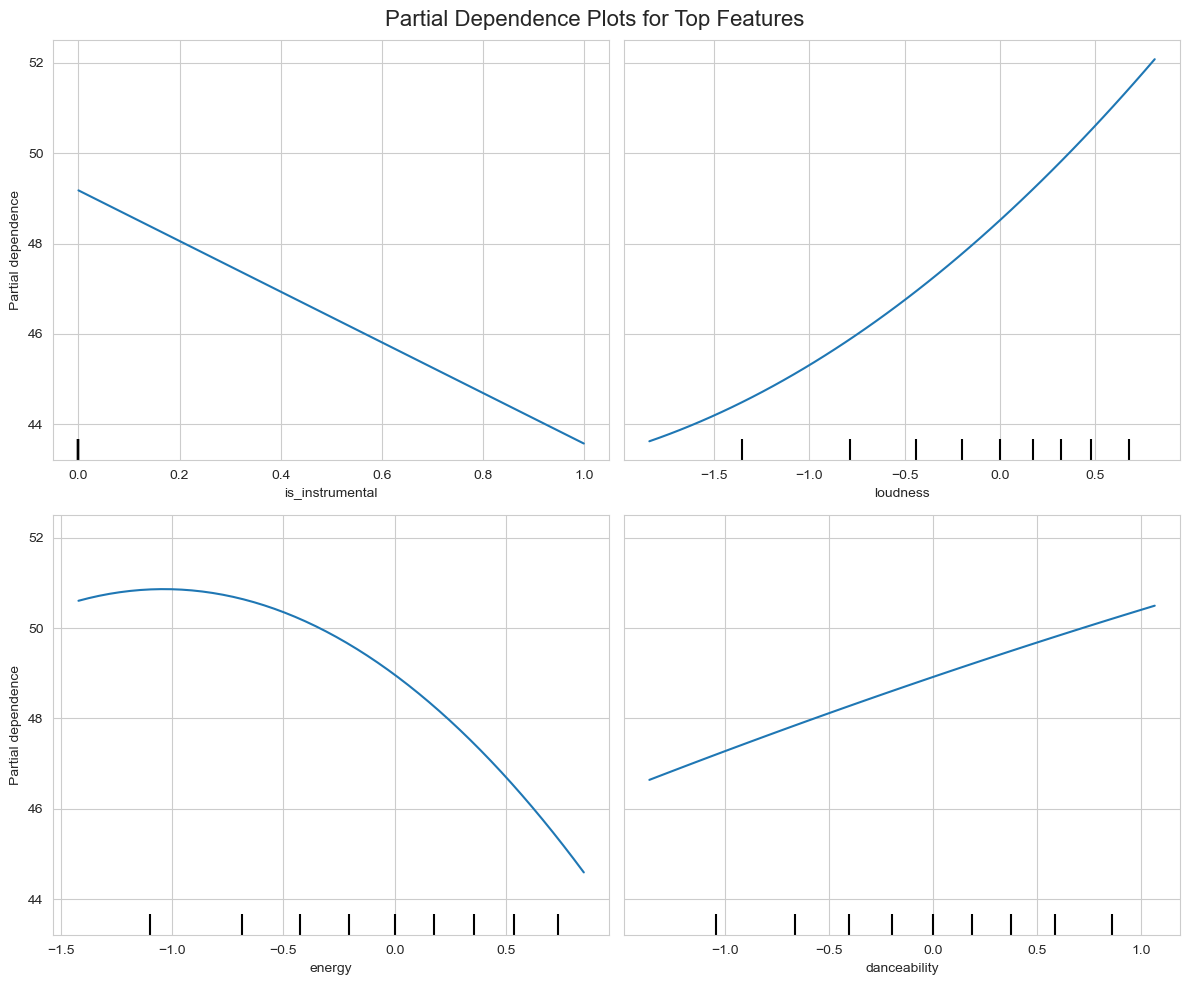

In [33]:
# PDP for top 4 features
features_to_plot = ['is_instrumental', 'loudness', 'energy', 'danceability']

fig, ax = plt.subplots(figsize=(12, 10), ncols=2, nrows=2)

PartialDependenceDisplay.from_estimator(
    best_estimator,
    X_train5,
    features_to_plot,
    kind='average',
    n_jobs=-1,
    grid_resolution=50,
    random_state=42,
    ax=ax
)

plt.suptitle('Partial Dependence Plots for Top Features', fontsize=16)
plt.tight_layout()
plt.show()

**is_instrumental:**
- Xu hướng: Mối quan hệ tuyến tính âm (giảm dần)
- Ý nghĩa: Khi một bài hát chuyển từ ít nhạc không lời (~0) sang hoàn toàn là nhạc không lời (~1), mức độ phổ biến dự đoán giảm rõ rệt (từ ~49 xuống ~44).

**loudness:**
- Xu hướng: Mối quan hệ phi tuyến tính, hình parabol ngửa.
- Ý nghĩa: Khi độ to loudness tăng (từ -1.5 lên 1.0), mức độ phổ biến dự đoán tăng nhanh (từ ~44 lên ~51).

**energy:**
- Xu hướng: Mối quan hệ phi tuyến tính, hình parabol úp. Đạt đỉnh ở -1.
- Ý nghĩa: Khi energy tăng hoặc giảm từ điểm này, mức độ phổ biến dự đoán đều giảm.

**danceability:**
- Xu hướng: Mối quan hệ tuyến tính dương nhưng hơi phi tuyến (hơi cong).
- Ý nghĩa: Tăng chậm đầu, tăng nhanh hơn từ 0.5-0.8; Khi độ phù hợp để nhảy danceability tăng, mức độ phổ biến dự đoán tăng theo nhất quán.

# KIỂM TRA GIẢ ĐỊNH

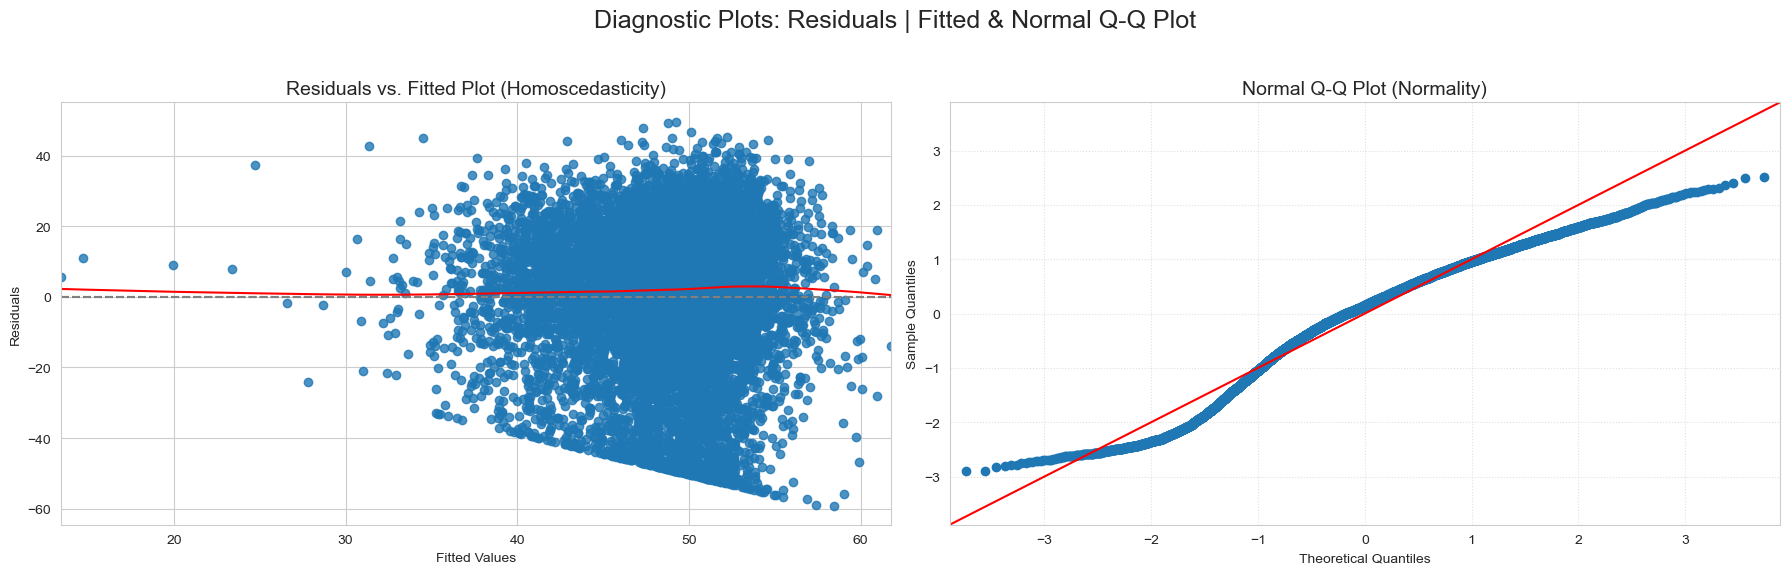

In [34]:
X_train_for_check = X_train5
y_train_for_check = y_train

# 1. Lấy giá trị dự đoán (fitted values) từ mô hình Lasso trên tập train
fitted_values_lasso = best_model_lasso.predict(X_train_for_check)

# 2. Tính phần dư (residuals)
residuals_lasso = y_train_for_check - fitted_values_lasso

# 3. Vẽ biểu đồ Residuals vs. Fitted
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Diagnostic Plots: Residuals | Fitted & Normal Q-Q Plot', fontsize=18)

# Residuals vs. Fitted ---
sns.residplot(x=fitted_values_lasso, y=residuals_lasso, lowess=True, line_kws={'color': 'red', 'lw': 1.5},ax=axes[0])
axes[0].set_title('Residuals vs. Fitted Plot (Homoscedasticity)', fontsize=14)
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].axhline(y=0, color='grey', linestyle='--')

# Normal Q-Q Plot ---
sm.qqplot(residuals_lasso, line='45',fit=True,ax=axes[1])
axes[1].set_title('Normal Q-Q Plot (Normality)', fontsize=14)
axes[1].grid(True, linestyle=':', alpha=0.6)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Tính tuyến tính**
- Đường màu đỏ (đường xu hướng của phần dư) rất bằng phẳng và nằm sát đường 0, gần như không có độ cong đáng kể
- Điều này cho thấy mô hình đã phản ánh tốt mối quan hệ trong dữ liệu. Giả định về tính tuyến tính (rằng phần dư có trung bình bằng 0 trên toàn dải dự đoán) đã được đáp ứng tốt.

**Phương sai đồng đều**
- Biểu đồ phần dư có dạng hình phễu ngang, các giá trị dự đoán càng cao, phân dư càng lớn. Tức là phương sai khi dự đoán của các giá trị lớn và giá trị nhỏ không đồng đều. 
- Điều này làm cho các ước lượng của mô hình trở nên không đáng tin cậy.

**Phân phối chuẩn của phần dư (Normality)**
- Phần lớn các điểm dữ liệu ở trung tâm phân bố bám rất sát vào đường chéo màu đỏ
- Tuy nhiên, có một sự sai lệch nhẹ ở hai đầu, các điểm có xu hướng cong ra khỏi đường thẳng. Điều này cho thấy phân phối của phần dư có "đuôi" nhẹ hơn so với một phân phối chuẩn hoàn hảo ==> Mô hình có ít các giá trị sai số cực đoan hơn so với dự kiến.
- Mặc dù không hoàn hảo, giả định về tính chuẩn của phần dư được đáp ứng ở mức độ khá tốt và chấp nhận được. Sự sai lệch này không quá nghiêm trọng.

# Best model:


- We have identify that the Lasso Polynomial provides the best performance so far. In this section, we will perform it on actual test set

In [35]:
# Final Evaluation on Test Set
# We will use the best model found in previous step

testX = None
    
if best_model_input_type == 'X_test_All':
    testX = X_test2  # For Model 5
    
elif best_model_input_type == 'X_test_RFE':
    testX = X_test2[selected_features] # For Models 2, 3, and 4

y_test_pred = best_estimator.predict(testX)

r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print("\nFinal Evaluation on Test Set:")
print(f"R² (Test):   {r2_test:.6f}")
print(f"RMSE (Test): {rmse_test:.6f}")
print(f"MAE (Test):  {mae_test:.6f}")

print("\nCompare (Test vs. Valid)")
print(f"RMSE (Valid): {best_model_row['RMSE (Valid)']:.6f}")
print(f"RMSE (Test):  {rmse_test:.6f}")


Final Evaluation on Test Set:
R² (Test):   0.045141
RMSE (Test): 19.955944
MAE (Test):  15.689355

Compare (Test vs. Valid)
RMSE (Valid): 20.068696
RMSE (Test):  19.955944


- Result is quite close to the train and valid set. This indicates that our models is stable.
- Still, the result is extremely low, only 4.5%. This means 95.5% of the data's variance cannot be explained by linear methods (even quadratic ones).

# CODE FOR USING LASSO MODEL TO PREDICT ON NEW DATASET

In [36]:
def preprocess_and_predict_correct(new_test_df, trained_model, scaler_1, cols_to_scale, loudness_cap, final_train_columns):
    """
    Hàm này xử lý dữ liệu test thô một cách chính xác để tương thích
    với mô hình đã được huấn luyện theo logic "scale 2 lần".
    """
    df = new_test_df.copy()

    # ---- BƯỚC 1: TIỀN XỬ LÝ BAN ĐẦU ----
    df['song_duration_ms'] = np.log(df['song_duration_ms'])
    df['liveness'] = np.log(df['liveness'])
    df['speechiness'] = np.log1p(df['speechiness'])
    df['loudness'] = df['loudness'].clip(lower=loudness_cap)
    df['is_instrumental'] = (df['instrumentalness'] > 0.5).astype(int)
    df.drop('instrumentalness', axis=1, inplace=True)
    encode = ['key', 'time_signature']
    df = pd.get_dummies(df, columns=encode, drop_first=True)
    df = df.reindex(columns=final_train_columns, fill_value=0)

    # ---- BƯỚC 2: ÁP DỤNG LẦN SCALE THỨ NHẤT ----
    df[cols_to_scale] = scaler_1.transform(df[cols_to_scale])

    # ---- BƯỚC 3: DỰ ĐOÁN BẰNG PIPELINE ----
    predictions = trained_model.predict(df)

    return predictions